In [73]:
import pandas as pd
import numpy as np
from io import StringIO
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
from sklearn.metrics import precision_recall_curve, auc

import requests
from sklearn.model_selection import train_test_split
from statistics import mean
import time
from io import StringIO
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from tqdm import tqdm
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import warnings
from collections import Counter
import pandas as pd
import pubchempy as pcp
from sklearn.metrics import jaccard_score
from itertools import combinations
import pubchempy as pcp
from collections import Counter
import numpy as np
from sklearn.metrics import jaccard_score
import requests
from tqdm import tqdm
import pandas as pd
from statistics import mean
from bs4 import BeautifulSoup
import json
import csv
from tqdm import tqdm
import pandas as pd 
from io import StringIO
from tqdm import tqdm
import itertools
from sklearn.model_selection import train_test_split
import re
#Ignore warning
import warnings
warnings.filterwarnings("ignore")
#Ignore warning
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np 
#plotting packages
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
import seaborn as sns
#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
#metrics
import math
from statistics import mean, stdev
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
# Ignore all warnings
warnings.filterwarnings('ignore')

  ### Outline
  
- [Methods](#0)
- [Loading Datasets](#1)
- [Evaluation](#3)
    - [Ratio 1:1](#3.1)
    - [Ratio 1:5](#3.2)        
    - [Ratio 1:10](#3.3)        

# 

<a name="0"></a>
**Methods**

In [2]:
def remove_labels_with_numbers(text):
    # Use a regular expression to remove numbers that appear as labels
    return re.sub(r'\d+', '', text)

In [3]:
def similarity_smile(smiles1,smiles2):
    score = 0
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is not None and mol2 is not None:
        fp1 = AllChem.GetMorganFingerprint(mol1, 2)  # Change radius as needed
        fp2 = AllChem.GetMorganFingerprint(mol2, 2)  # Change radius as needed
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        score = tanimoto_similarity
    else:
        score = -1
    return score

In [4]:
def generate_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Function to count k-mers
def count_kmers(kmers):
    return Counter(kmers)

# Function to calculate similarity score
def calculate_similarity(seq1, seq2, k):
    kmers_seq1 = generate_kmers(seq1, k)
    kmers_seq2 = generate_kmers(seq2, k)
    
    count_kmers_seq1 = count_kmers(kmers_seq1)
    count_kmers_seq2 = count_kmers(kmers_seq2)
    
    common_kmers = set(count_kmers_seq1.keys()) & set(count_kmers_seq2.keys())
    common_count = sum(min(count_kmers_seq1[kmer], count_kmers_seq2[kmer]) for kmer in common_kmers)
    total_count = sum(count_kmers_seq1.values()) + sum(count_kmers_seq2.values())
    
    similarity = common_count / total_count
    return similarity

In [5]:
def generate_random_combinations(num_combinations, all_drugs, all_targets, df_original):
    # Generate all possible combinations
    all_combinations = pd.MultiIndex.from_product([all_targets, all_drugs], names=['Protein', 'Drug']).to_frame(index=False)
    
    # Drop combinations that are in the original DataFrame
    filtered_combinations = all_combinations[~all_combinations.set_index(['Protein', 'Drug']).index.isin(df_original.set_index(['Protein', 'Drug']).index)]
    
    # Sample randomly from the filtered combinations
    sampled_combinations = filtered_combinations.sample(n=num_combinations, random_state=42)
    
    # Create the label column
    sampled_combinations['Label'] = 0
    
    return sampled_combinations


In [6]:
def confusionMat_v2(Y_test, y_pred, y_prob, modelName):
    cf_matrix = confusion_matrix(Y_test, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    fpr, tpr, thresh = roc_curve(Y_test, y_prob, pos_label=1)
    auc = roc_auc_score(Y_test, y_prob)
    

    auprc = average_precision_score(Y_test, y_prob)
    precision_class0 = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[1, 0])
    recall_class0 = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[0, 1])

    precision_class1 = cf_matrix[1, 1] / (cf_matrix[1, 1] + cf_matrix[0, 1])
    recall_class1 = cf_matrix[1, 1] / (cf_matrix[1, 1] + cf_matrix[1, 0])

    accuracy = accuracy_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)

    print("\n", modelName, "...................................\n") 
    print("Accuracy:", accuracy)
    print("F1-Score:", f1)
    print("AUPRC:", auprc)
    print("AUROC:", auc)
    print("PrecisionClass0:", precision_class0)
    print("RecallClass0:", recall_class0)
    print("PrecisionClass1:", precision_class1)
    print("RecallClass1:", recall_class1)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax[0])
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    print(classification_report(Y_test, y_pred, zero_division=1))
    return auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1,cf_matrix[1, 1]

In [56]:
columns = ['Data','AUPRC', 'AUROC', 'PrecisionClass0', 'RecallClass0', 'PrecisionClass1', 'RecallClass1', 'Accuracy', 'F1']
metricTable= pd.DataFrame(columns=columns)
metricTable

,Data,AUPRC,AUROC,PrecisionClass0,RecallClass0,PrecisionClass1,RecallClass1,Accuracy,F1


# 

<a name="1"></a>
**Loading Datasets**

- Mapping

In [8]:
mapping = pd.read_csv("../../../Dataset/Squad/Enzyme/drug_protein_interactions_Enzyme.csv")
mapping

,Protein,Drug
0,hsa10,D00002
1,hsa107,D00002
2,hsa108,D00002
3,hsa109,D00002
4,hsa111,D00002
...,...,...
2921,hsa1576,D05353
2922,hsa476,D05353
2923,hsa30,D05407
2924,hsa4129,D05458


In [9]:
all_drugs = mapping['Drug'].unique().tolist()
all_targets = mapping['Protein'].unique().tolist()

- Features

In [14]:
# smile_drug = pd.read_csv("../../../Dataset/Squad/Enzyme/ID_drugs_df_Enzyme.csv", header=None, names=['Index', 'DrugID', 'SMILE'])
# smile_drug = smile_drug.drop("Index",axis=1)
# smile_drug.to_csv("../../../Dataset/Squad/Enzyme/drugs_smile.csv",index=False)

In [24]:
smile_drug = pd.read_csv("../../../Dataset/Squad/Enzyme/drugs_smile.csv")
smile_drug

,DrugID,SMILE
0,D00002,NC(=O)c1ccc[n+](c1)[C@@H]1O[C@H](COP(O)(=O)OP(...
1,D00005,CC1=CC2=C(C=C1C)N(C[C@H](O)[C@H](O)[C@H](O)CO[...
2,D00007,N[C@@H](CCC(O)=O)C(O)=O
3,D00014,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(O)=O)C(O)=O
4,D00018,[H][C@@]1(OC(=O)C(O)=C1O)[C@@H](O)CO
...,...,...
440,D05341,CCCCCCCCCCCCCCCC(O)=O
441,D05353,COC1=C(OC)C(CS(=O)C2=NC3=C(N2)C=C(OC(F)F)C=C3)...
442,D05407,NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2
443,D05458,CC(C)(N)CC1=CC=CC=C1


In [16]:
# sequence_target = pd.read_csv("../../../Dataset/Squad/Enzyme/ID_targets_df_Enzyme.csv", header=None, names=['Index', 'TargetID', 'Sequence'])
# sequence_target = sequence_target.drop("Index",axis=1)
# sequence_target.to_csv("../../../Dataset/Squad/Enzyme/targets_sequence.csv",index=False)

In [25]:
sequence_target = pd.read_csv("../../../Dataset/Squad/Enzyme/targets_sequence.csv")
sequence_target

,TargetID,Sequence
0,hsa10,MDIEAYFERIGYKNSRNKLDLETLTDILEHQIRAVPFENLNMHCGQ...
1,hsa107,MAGAPRGGGGGGGGAGEPGGAERAAGTSRRRGLRACDEEFACPELE...
2,hsa108,MWQEAMRRRRYLRDRSEEAAGGGDGLPRSRDWLYESYYCMSQQHPL...
3,hsa109,MPRNQGFSEPEYSAEYSAEYSVSLPSDPDRGVGRTHEISVRNSGSC...
4,hsa111,MSGSKSVSPPGYAAQKTAAPAPRGGPEHRSAWGEADSRANGYPHAP...
...,...,...
659,hsa9601,MRPRKAFLLLLLLGLVQLLAVAGAEGPDEDSSNRENAIEDEEEEEE...
660,hsa3988,MKMRFLGLVVCLVLWTLHSEGSGGKLTAVDPETNMNVSEIISYWGF...
661,hsa4143,MNGPVDGLCDHSLSEGVFMFTSESVGEGHPDKICDQISDAVLDAHL...
662,hsa4482,MLSATRRACQLLLLHSLFPVPRMGNSASNIVSPQEALPGRKEQTPV...


**Similarity**

- Drug Similarity

In [26]:
data_drug = np.zeros((len(all_drugs), len(all_drugs)))
sim_SMILE = pd.DataFrame(data_drug, index=all_drugs, columns=all_drugs)
sim_SMILE

,D00002,D00005,D00007,D00014,D00018,D00021,D00027,D00029,D00032,D00035,...,D04092,D04197,D04292,D04966,D04983,D05341,D05353,D05407,D05458,D06238
D00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D00018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D05341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D05353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D05407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D05458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
for id1 in tqdm(all_drugs, desc="Processing drugs smiles"):
    for id2 in all_drugs:
        smiles1 = smile_drug[smile_drug['DrugID'] == id1]['SMILE'].values[0]
        smiles2 = smile_drug[smile_drug['DrugID'] == id2]['SMILE'].values[0]
        score = similarity_smile(smiles1, smiles2)
        sim_SMILE.loc[id1][id2] = score
        sim_SMILE.loc[id2][id1] = score

sim_SMILE

Processing drugs smiles:   0%|                                                                                                     | 0/445 [00:00<?, ?it/s][16:33:45] WARNING: not removing hydrogen atom without neighbors
[16:33:45] WARNING: not removing hydrogen atom without neighbors
[16:33:46] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:   0%|▏                                                                                            | 1/445 [00:00<06:26,  1.15it/s][16:33:46] WARNING: not removing hydrogen atom without neighbors
[16:33:46] WARNING: not removing hydrogen atom without neighbors
[16:33:47] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:   0%|▍                                                                                            | 2/445 [00:01<06:40,  1.10it/s][16:33:47] WARNING: not removing hydrogen atom without neighbors
[16:33:47] WARNING: not removing hydrogen atom without neighbors
[16:33:47] WARN

Processing drugs smiles:  10%|█████████▌                                                                                  | 46/445 [00:30<04:52,  1.37it/s][16:34:16] WARNING: not removing hydrogen atom without neighbors
[16:34:16] WARNING: not removing hydrogen atom without neighbors
[16:34:17] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  11%|█████████▋                                                                                  | 47/445 [00:31<05:01,  1.32it/s][16:34:17] WARNING: not removing hydrogen atom without neighbors
[16:34:17] WARNING: not removing hydrogen atom without neighbors
[16:34:17] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  11%|█████████▉                                                                                  | 48/445 [00:32<04:43,  1.40it/s][16:34:18] WARNING: not removing hydrogen atom without neighbors
[16:34:18] WARNING: not removing hydrogen atom without neighbors
[16:34:18] WARN

Processing drugs smiles:  21%|███████████████████                                                                         | 92/445 [01:03<03:52,  1.52it/s][16:34:49] WARNING: not removing hydrogen atom without neighbors
[16:34:49] WARNING: not removing hydrogen atom without neighbors
[16:34:49] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  21%|███████████████████▏                                                                        | 93/445 [01:03<03:57,  1.48it/s][16:34:49] WARNING: not removing hydrogen atom without neighbors
[16:34:49] WARNING: not removing hydrogen atom without neighbors
[16:34:50] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  21%|███████████████████▍                                                                        | 94/445 [01:04<03:49,  1.53it/s][16:34:50] WARNING: not removing hydrogen atom without neighbors
[16:34:50] WARNING: not removing hydrogen atom without neighbors
[16:34:50] WARN

Processing drugs smiles:  31%|████████████████████████████▏                                                              | 138/445 [01:35<03:23,  1.51it/s][16:35:20] WARNING: not removing hydrogen atom without neighbors
[16:35:20] WARNING: not removing hydrogen atom without neighbors
[16:35:21] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  31%|████████████████████████████▍                                                              | 139/445 [01:35<03:20,  1.53it/s][16:35:21] WARNING: not removing hydrogen atom without neighbors
[16:35:21] WARNING: not removing hydrogen atom without neighbors
[16:35:21] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  31%|████████████████████████████▋                                                              | 140/445 [01:36<03:23,  1.50it/s][16:35:22] WARNING: not removing hydrogen atom without neighbors
[16:35:22] WARNING: not removing hydrogen atom without neighbors
[16:35:22] WARN

Processing drugs smiles:  41%|█████████████████████████████████████▋                                                     | 184/445 [02:05<02:54,  1.50it/s][16:35:51] WARNING: not removing hydrogen atom without neighbors
[16:35:51] WARNING: not removing hydrogen atom without neighbors
[16:35:52] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  42%|█████████████████████████████████████▊                                                     | 185/445 [02:06<03:00,  1.44it/s][16:35:52] WARNING: not removing hydrogen atom without neighbors
[16:35:52] WARNING: not removing hydrogen atom without neighbors
[16:35:52] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  42%|██████████████████████████████████████                                                     | 186/445 [02:07<03:06,  1.39it/s][16:35:53] WARNING: not removing hydrogen atom without neighbors
[16:35:53] WARNING: not removing hydrogen atom without neighbors
[16:35:53] WARN

Processing drugs smiles:  52%|███████████████████████████████████████████████                                            | 230/445 [02:38<03:01,  1.18it/s][16:36:24] WARNING: not removing hydrogen atom without neighbors
[16:36:24] WARNING: not removing hydrogen atom without neighbors
[16:36:24] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  52%|███████████████████████████████████████████████▏                                           | 231/445 [02:39<02:51,  1.25it/s][16:36:25] WARNING: not removing hydrogen atom without neighbors
[16:36:25] WARNING: not removing hydrogen atom without neighbors
[16:36:25] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  52%|███████████████████████████████████████████████▍                                           | 232/445 [02:39<02:43,  1.31it/s][16:36:25] WARNING: not removing hydrogen atom without neighbors
[16:36:25] WARNING: not removing hydrogen atom without neighbors
[16:36:26] WARN

[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not r

[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not r

[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not r

[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:39] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not r

[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not removing hydrogen atom without neighbors
[16:36:40] WARNING: not r

Processing drugs smiles:  64%|█████████████████████████████████████████████████████████▊                                 | 283/445 [03:16<01:54,  1.42it/s][16:37:02] WARNING: not removing hydrogen atom without neighbors
[16:37:02] WARNING: not removing hydrogen atom without neighbors
[16:37:02] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  64%|██████████████████████████████████████████████████████████                                 | 284/445 [03:17<01:48,  1.49it/s][16:37:03] WARNING: not removing hydrogen atom without neighbors
[16:37:03] WARNING: not removing hydrogen atom without neighbors
[16:37:03] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  64%|██████████████████████████████████████████████████████████▎                                | 285/445 [03:18<01:52,  1.42it/s][16:37:03] WARNING: not removing hydrogen atom without neighbors
[16:37:03] WARNING: not removing hydrogen atom without neighbors
[16:37:04] WARN

Processing drugs smiles:  74%|███████████████████████████████████████████████████████████████████▎                       | 329/445 [03:50<01:28,  1.30it/s][16:37:36] WARNING: not removing hydrogen atom without neighbors
[16:37:36] WARNING: not removing hydrogen atom without neighbors
[16:37:37] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  74%|███████████████████████████████████████████████████████████████████▍                       | 330/445 [03:51<01:24,  1.36it/s][16:37:37] WARNING: not removing hydrogen atom without neighbors
[16:37:37] WARNING: not removing hydrogen atom without neighbors
[16:37:37] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  74%|███████████████████████████████████████████████████████████████████▋                       | 331/445 [03:52<01:21,  1.40it/s][16:37:38] WARNING: not removing hydrogen atom without neighbors
[16:37:38] WARNING: not removing hydrogen atom without neighbors
[16:37:38] WARN

Processing drugs smiles:  84%|████████████████████████████████████████████████████████████████████████████▋              | 375/445 [04:23<00:51,  1.37it/s][16:38:09] WARNING: not removing hydrogen atom without neighbors
[16:38:09] WARNING: not removing hydrogen atom without neighbors
[16:38:09] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  84%|████████████████████████████████████████████████████████████████████████████▉              | 376/445 [04:24<00:49,  1.40it/s][16:38:10] WARNING: not removing hydrogen atom without neighbors
[16:38:10] WARNING: not removing hydrogen atom without neighbors
[16:38:10] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  85%|█████████████████████████████████████████████████████████████████████████████              | 377/445 [04:25<00:47,  1.43it/s][16:38:10] WARNING: not removing hydrogen atom without neighbors
[16:38:10] WARNING: not removing hydrogen atom without neighbors
[16:38:11] WARN

Processing drugs smiles:  95%|██████████████████████████████████████████████████████████████████████████████████████     | 421/445 [04:58<00:19,  1.25it/s][16:38:44] WARNING: not removing hydrogen atom without neighbors
[16:38:44] WARNING: not removing hydrogen atom without neighbors
[16:38:44] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 422/445 [04:58<00:17,  1.32it/s][16:38:44] WARNING: not removing hydrogen atom without neighbors
[16:38:44] WARNING: not removing hydrogen atom without neighbors
[16:38:45] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 423/445 [04:59<00:16,  1.30it/s][16:38:45] WARNING: not removing hydrogen atom without neighbors
[16:38:45] WARNING: not removing hydrogen atom without neighbors
[16:38:46] WARN

[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not r

[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not r

[16:38:50] WARNING: not removing hydrogen atom without neighbors
[16:38:50] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 430/445 [05:05<00:11,  1.29it/s][16:38:51] WARNING: not removing hydrogen atom without neighbors
[16:38:51] WARNING: not removing hydrogen atom without neighbors
[16:38:51] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 431/445 [05:05<00:10,  1.29it/s][16:38:51] WARNING: not removing hydrogen atom without neighbors
[16:38:51] WARNING: not removing hydrogen atom without neighbors
[16:38:52] WARNING: not removing hydrogen atom without neighbors
Processing drugs smiles:  97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 432/445 [05:06<00:09,  1.32it/s][16:38:52] WARN

,D00002,D00005,D00007,D00014,D00018,D00021,D00027,D00029,D00032,D00035,...,D04092,D04197,D04292,D04966,D04983,D05341,D05353,D05407,D05458,D06238
D00002,1.000000,0.430108,0.065693,0.061350,0.078014,0.100000,0.051471,0.070968,0.078571,0.036232,...,0.087838,0.120805,0.096970,0.021429,0.051095,0.036145,0.102273,0.125000,0.070922,0.107345
D00005,0.430108,1.000000,0.049383,0.064865,0.086420,0.059524,0.063694,0.067416,0.067073,0.024540,...,0.075581,0.136905,0.090426,0.018293,0.043478,0.031579,0.141361,0.147059,0.054217,0.164021
D00007,0.065693,0.049383,1.000000,0.425926,0.098039,0.260870,0.044444,0.186441,0.279070,0.119048,...,0.083333,0.075758,0.011905,0.068182,0.454545,0.151515,0.031579,0.119403,0.037736,0.020408
D00014,0.061350,0.064865,0.425926,1.000000,0.064103,0.164384,0.027778,0.141176,0.171429,0.072464,...,0.057471,0.053763,0.009009,0.057143,0.250000,0.119565,0.024590,0.108696,0.025000,0.024194
D00018,0.078014,0.086420,0.098039,0.064103,1.000000,0.084746,0.081633,0.085714,0.089286,0.060000,...,0.075758,0.166667,0.083333,0.000000,0.080000,0.037975,0.061224,0.157143,0.033898,0.039216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D05341,0.036145,0.031579,0.151515,0.119565,0.037975,0.076923,0.013889,0.200000,0.080000,0.073529,...,0.045977,0.031915,0.018349,0.028169,0.121212,1.000000,0.024793,0.063158,0.025316,0.016129
D05353,0.102273,0.141361,0.031579,0.024590,0.061224,0.115789,0.091954,0.035088,0.095745,0.021505,...,0.153061,0.081818,0.146552,0.021505,0.043478,0.024793,1.000000,0.128440,0.119565,0.286957
D05407,0.125000,0.147059,0.119403,0.108696,0.157143,0.092105,0.107692,0.104651,0.142857,0.043478,...,0.111111,0.156627,0.067961,0.014085,0.106061,0.063158,0.128440,1.000000,0.052632,0.096491
D05458,0.070922,0.054217,0.037736,0.025000,0.033898,0.431818,0.083333,0.027397,0.090909,0.000000,...,0.272727,0.041096,0.111111,0.061224,0.060000,0.025316,0.119565,0.052632,1.000000,0.117021


- Target Similarity 

In [28]:
data_targets = np.zeros((len(all_targets), len(all_targets)))
seq_SIM = pd.DataFrame(data_targets, index=all_targets, columns=all_targets)
seq_SIM

,hsa10,hsa107,hsa108,hsa109,hsa111,hsa112,hsa113,hsa114,hsa115,hsa124,...,hsa2339,hsa2342,hsa1429,hsa2766,hsa51292,hsa9601,hsa3988,hsa4143,hsa4482,hsa5538
hsa10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa9601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa3988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa4143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa4482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
num_sequences = len(all_targets)
# Fill the similarity matrix
for i in tqdm(range(num_sequences), desc='Computing similarity matrix'):
    for j in range(i, num_sequences):
        seq1 = sequence_target.iloc[i]['Sequence']
        seq2 = sequence_target.iloc[j]['Sequence']
        
        # Perform global alignment
        alignments = pairwise2.align.globalxx(seq1, seq2)
        
        # Extract the alignment score (highest score)
        max_score = max(alignments, key=lambda x: x[2])[2]
        
        # Fill the matrix (symmetric matrix)
        seq_SIM.iloc[i, j] = max_score
        seq_SIM.iloc[j, i] = max_score

Computing similarity matrix: 100%|█████████████████████████████████████████████████████████████████████████████████████| 664/664 [2:35:07<00:00, 14.02s/it]


In [36]:
seq_SIM

,hsa338442,hsa1812,hsa1813,hsa5739,hsa9052,hsa148,hsa153,hsa154,hsa64805,hsa1814,...,hsa23620,hsa7201,hsa6753,hsa6755,hsa4543,hsa1234,hsa886,hsa887,hsa5729,hsa6010
hsa338442,363.0,157.0,142.0,143.0,135.0,155.0,145.0,148.0,146.0,143.0,...,147.0,144.0,156.0,151.0,141.0,146.0,149.0,145.0,134.0,137.0
hsa1812,157.0,446.0,185.0,159.0,141.0,203.0,206.0,193.0,159.0,176.0,...,165.0,168.0,167.0,161.0,154.0,151.0,178.0,178.0,147.0,151.0
hsa1813,142.0,185.0,443.0,151.0,145.0,186.0,186.0,176.0,140.0,260.0,...,163.0,162.0,160.0,155.0,147.0,146.0,163.0,168.0,148.0,142.0
hsa5739,143.0,159.0,151.0,386.0,146.0,167.0,171.0,153.0,133.0,149.0,...,158.0,148.0,162.0,156.0,145.0,140.0,149.0,164.0,182.0,134.0
hsa9052,135.0,141.0,145.0,146.0,357.0,149.0,151.0,145.0,135.0,140.0,...,146.0,140.0,141.0,134.0,131.0,139.0,148.0,149.0,134.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa1234,146.0,151.0,146.0,140.0,139.0,163.0,149.0,143.0,146.0,147.0,...,137.0,142.0,163.0,149.0,140.0,352.0,158.0,151.0,137.0,137.0
hsa886,149.0,178.0,163.0,149.0,148.0,174.0,182.0,165.0,154.0,165.0,...,164.0,171.0,165.0,163.0,151.0,158.0,428.0,241.0,144.0,156.0
hsa887,145.0,178.0,168.0,164.0,149.0,177.0,193.0,165.0,145.0,172.0,...,175.0,169.0,179.0,172.0,152.0,151.0,241.0,447.0,158.0,156.0
hsa5729,134.0,147.0,148.0,182.0,134.0,154.0,151.0,136.0,123.0,143.0,...,151.0,137.0,147.0,138.0,133.0,137.0,144.0,158.0,359.0,130.0


In [31]:
k=1
kmer_1_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_1_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [09:43<00:00,  1.14it/s]


In [32]:
k=2
kmer_2_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_2_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [11:54<00:00,  1.08s/it]


In [33]:
k=3
kmer_3_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_3_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [11:50<00:00,  1.07s/it]


In [34]:
k=4
kmer_4_similarity = pd.DataFrame(index=all_targets, columns=all_targets)

for id1 in tqdm(all_targets, desc="Calculating Similarity", total=len(all_targets)):
    for id2 in all_targets:
        seq1 = sequence_target[sequence_target['TargetID'] == id1]['Sequence'].iloc[0]
        seq2 = sequence_target[sequence_target['TargetID'] == id2]['Sequence'].iloc[0]
        
        score = 1  # Default score if IDs are the same
        if id1 != id2:
            score = calculate_similarity(seq1, seq2, k)
        
        kmer_4_similarity.loc[id1, id2] = score

Calculating Similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [11:45<00:00,  1.06s/it]


In [35]:
#Save Similarities
sim_SMILE.to_csv("../../../Dataset/Squad/Enzyme/Features/smile_similarity.csv")
seq_SIM.to_csv("../../../Dataset/Squad/Enzyme/Features/seq_SIM.csv")
kmer_1_similarity.to_csv("../../../Dataset/Squad/Enzyme/Features/kmer_1_similarity.csv")
kmer_2_similarity.to_csv("../../../Dataset/Squad/Enzyme/Features/kmer_2_similarity.csv")
kmer_3_similarity.to_csv("../../../Dataset/Squad/Enzyme/Features/kmer_3_similarity.csv")
kmer_4_similarity.to_csv("../../../Dataset/Squad/Enzyme/Features/kmer_4_similarity.csv")

In [30]:
#Load Similarities
sim_SMILE = pd.read_csv("../../../Dataset/Squad/Enzyme/Features/smile_similarity.csv")
#SIMMAT
HLCS_simmat_dc         = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/HLCS_e_simmat_dc.txt' , sep='\t')
NLCS_simmat_dc         = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/NLCS_e_simmat_dc.txt' , sep='\t')
TFIDF_simmat_simmat_dc = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/TFIDF_e_simmat_dc.txt' , sep='\t')
TF_simmat_simmat_dc    = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/TF_e_simmat_dc.txt' , sep='\t')
complingo4_simmat_dc   = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/complingo4_e_simmat_dc.txt' , sep='\t')
comptfidf_simmat_dc    = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/comptfidf_e_simmat_dc.txt' , sep='\t')
edit_simmat_dc         = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/edit_e_simmat_dc.txt' , sep='\t')
lingo3_simmat_dc       = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/lingo3_e_simmat_dc.txt' , sep='\t')
lingo4_simmat_dc       = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/lingo4_e_simmat_dc.txt' , sep='\t')
lingo5_simmat_dc       = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/lingo5_e_simmat_dc.txt' , sep='\t')
smifp34Man             = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/smifp34Man_e_simmat_dc.txt' , sep='\t')
smifp34Tan             = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/smifp34Tan_e_simmat_dc.txt' , sep='\t')
smifp38Man             = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/smifp38Man_e_simmat_dc.txt' , sep='\t')
smifp38Tan             = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/smifp38Tan_e_simmat_dc.txt' , sep='\t')
substring              = pd.read_csv('../../../Dataset/Squad/Enzyme/Features/substring_e_simmat_dc.txt' , sep='\t')

seq_SIM   = pd.read_csv("../../../Dataset/Squad/Enzyme/Features/seq_SIM.csv")
kmer_1_similarity = pd.read_csv("../../../Dataset/Squad/Enzyme/Features/kmer_1_similarity.csv")
kmer_2_similarity = pd.read_csv("../../../Dataset/Squad/Enzyme/Features/kmer_2_similarity.csv")
kmer_3_similarity = pd.read_csv("../../../Dataset/Squad/Enzyme/Features/kmer_3_similarity.csv")
kmer_4_similarity = pd.read_csv("../../../Dataset/Squad/Enzyme/Features/kmer_4_similarity.csv")
default_compound  = pd.read_csv("../../../Dataset/Squad/Enzyme/Features/e_simmat_dc.txt", delimiter='\t')
default_protein   = pd.read_csv("../../../Dataset/Squad/Enzyme/Features/e_simmat_dg.txt", delimiter='\t')

In [31]:
comptfidf_simmat_dc.iloc[:, 1:] =  comptfidf_simmat_dc.iloc[:, 1:].applymap(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x)

# 

<a name="3"></a>
### Evaluation

In [32]:
print("Dataset Enzyme with ", len(all_drugs) , " drugs and " , len(all_targets) , "targets including", len(mapping))

Dataset Enzyme with  445  drugs and  664 targets including 2926


In [33]:
#Random Negative Sampling 
mapping

,Protein,Drug
0,hsa10,D00002
1,hsa107,D00002
2,hsa108,D00002
3,hsa109,D00002
4,hsa111,D00002
...,...,...
2921,hsa1576,D05353
2922,hsa476,D05353
2923,hsa30,D05407
2924,hsa4129,D05458


<a name="3.1"></a>
### Ratio 1:1  
- [Evaluatuin](#3.1.0)
- [Feature Selection](#3.1.1)

In [91]:
# Generate a DataFrame with 2926 random combinations
num_combinations = len(mapping)
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all

,index,Protein,Drug,Label
0,0,hsa10,D00002,1
1,1,hsa107,D00002,1
2,2,hsa108,D00002,1
3,3,hsa109,D00002,1
4,4,hsa111,D00002,1
...,...,...,...,...
5847,5847,hsa64902,D03720,0
5848,5848,hsa79799,D00667,0
5849,5849,hsa8192,D00401,0
5850,5850,hsa635,D00593,0


In [92]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [93]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                    'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,             
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])
df_scores

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,kmer2_mean,kmer1_max,kmer1_mean,default_protein_max,default_protein_mean,default_compound_max,default_compound_mean,count_drug,count_target,target


In [94]:
for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    default_protein_max = 0
    default_compound_max = 0


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
       
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])

    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


5852it [03:20, 29.14it/s]                                                                                                                                  


In [95]:
df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']

df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']

df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']



df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']

df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']


In [96]:

df_scores

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00002,hsa10,0.117318,0.117318,0.05556,0.05556,0.15385,0.15385,0.02793,...,0.15385,0.02793,0.17687,0.11741,0.230769,0.122358,0.07353,0.060345,0.01563,0.32328
1,1,D00002,hsa107,0.483871,0.483871,0.15508,0.15508,0.39847,0.39847,0.46062,...,0.39847,0.46062,0.61625,0.38013,0.418803,0.30551,0.27137,0.2688,0.02381,0.58959
2,2,D00002,hsa108,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,D00002,hsa109,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,D00002,hsa111,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,5847,D03720,hsa64902,0.015748,0.015748,0.02985,0.02985,0.08224,0.08224,0.00000,...,0.08224,0.0,0.0,0.011111,0.140625,0.018182,0.0,0.0,0.02174,0.34259
5848,5848,D00667,hsa79799,0.169643,0.169643,0.06775,0.06775,0.19512,0.19512,0.16687,...,0.19512,0.16687,0.33083,0.218914,0.330579,0.196322,0.13116,0.077778,0.02564,0.41964
5849,5849,D00401,hsa8192,0.022222,0.011111,0.01058,0.00910,0.02564,0.02051,0.00000,...,0.04102,0.0,0.0,0.029412,0.176923,0.0,0.0,0.0,0.0943,0.22402
5850,5850,D00593,hsa635,0.076923,0.076923,0.10440,0.10440,0.30025,0.30025,0.00398,...,0.30025,0.00398,0.08551,0.030557,0.354839,0.084615,0.01667,0.009524,0.02857,0.30769


In [97]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

In [98]:
df_scores.columns

Index(['index', 'drugID', 'targetID', 'smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'target', 'adj_smile_max',
       'adj_sequence_max', 'adj_km

In [99]:
features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_default_protein_max', 'adj_default_compound_max',
       'adj_HLCS_max', 'adj_NLCS_max', 'adj_TFIDF_simmat_max',
       'adj_TF_simmat_max', 'adj_complingo_max', 'adj_edit_max',
       'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_comptfidf_max',
       'adj_comptfidf_mean', 'adj_smile_mean', 'adj_sequence_mean',
       'adj_kmer1_mean', 'adj_kmer2_mean', 'adj_kmer3_mean', 'adj_kmer4_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

Results of  Enzyme 1:1

 RandomForest ...................................

Accuracy: 0.946199829205807
F1-Score: 0.9472803347280334
AUPRC: 0.9890325411693114
AUROC: 0.985309406302018
PrecisionClass0: 0.9328743545611016
RecallClass0: 0.9575971731448764
PrecisionClass1: 0.9593220338983051
RecallClass1: 0.9355371900826446


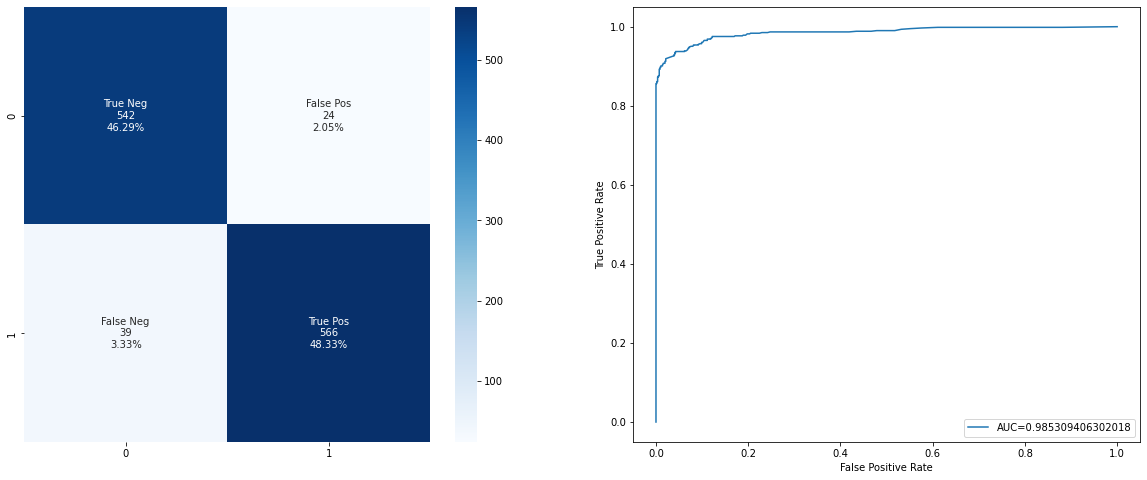

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       566
           1       0.96      0.94      0.95       605

    accuracy                           0.95      1171
   macro avg       0.95      0.95      0.95      1171
weighted avg       0.95      0.95      0.95      1171



In [57]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Enzyme 1:1'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

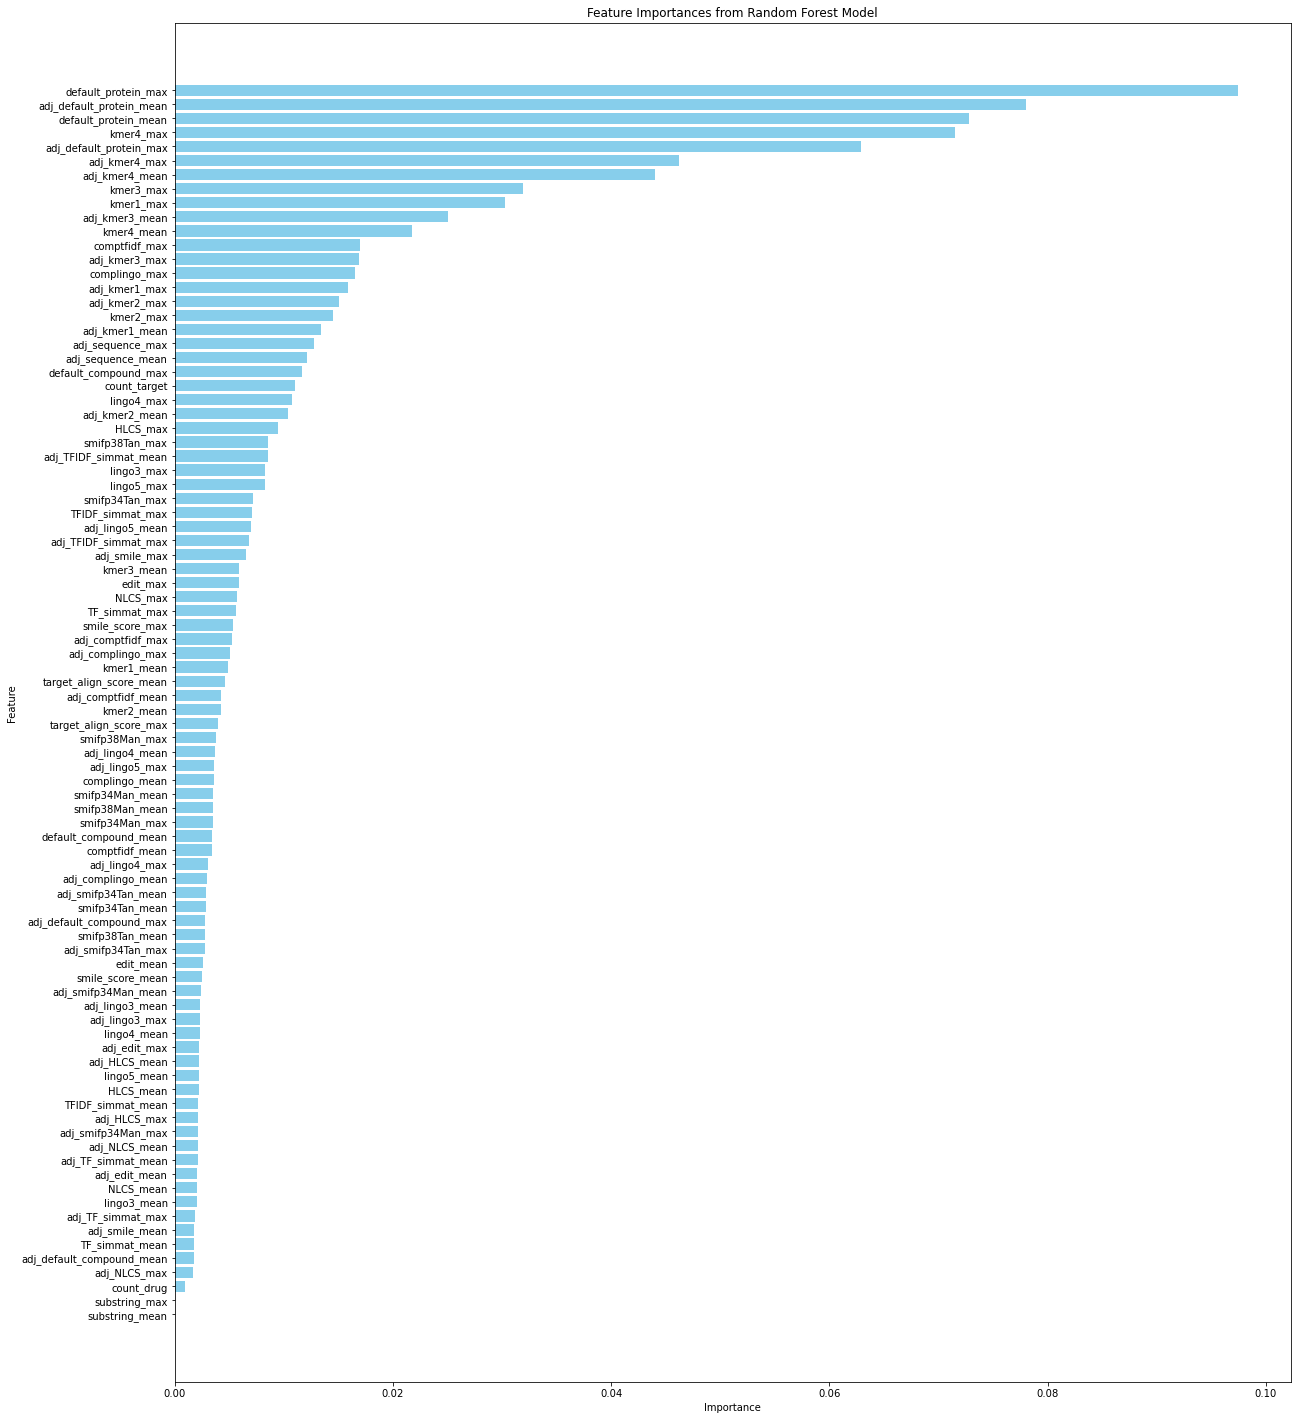

In [58]:
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 25))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# 

<a name="3.1.1"></a>
**Feature Selection**

In [60]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: default_protein_max - Accuracy: 0.8855678906917165
Added feature: lingo3_max - Accuracy: 0.9342442356959864
Added feature: TFIDF_simmat_mean - Accuracy: 0.9410760034158838
Added feature: target_align_score_max - Accuracy: 0.9444918872758327
Added feature: TF_simmat_max - Accuracy: 0.9479077711357814
Added feature: TFIDF_simmat_max - Accuracy: 0.9496157130657558
Added feature: count_target - Accuracy: 0.950469684030743
Added feature: adj_lingo5_mean - Accuracy: 0.9547395388556789
Added feature: lingo3_mean - Accuracy: 0.9564474807856533


KeyboardInterrupt: 

In [61]:
selected_features

['default_protein_max',
 'lingo3_max',
 'TFIDF_simmat_mean',
 'target_align_score_max',
 'TF_simmat_max',
 'TFIDF_simmat_max',
 'count_target',
 'adj_lingo5_mean',
 'lingo3_mean']

Results of  Enzyme 1:1 top_features

 RandomForest ...................................

Accuracy: 0.9564474807856533
F1-Score: 0.9567430025445293
AUPRC: 0.9875779200177841
AUROC: 0.9827439184650877
PrecisionClass0: 0.931323283082077
RecallClass0: 0.9823321554770318
PrecisionClass1: 0.9825783972125436
RecallClass1: 0.9322314049586777


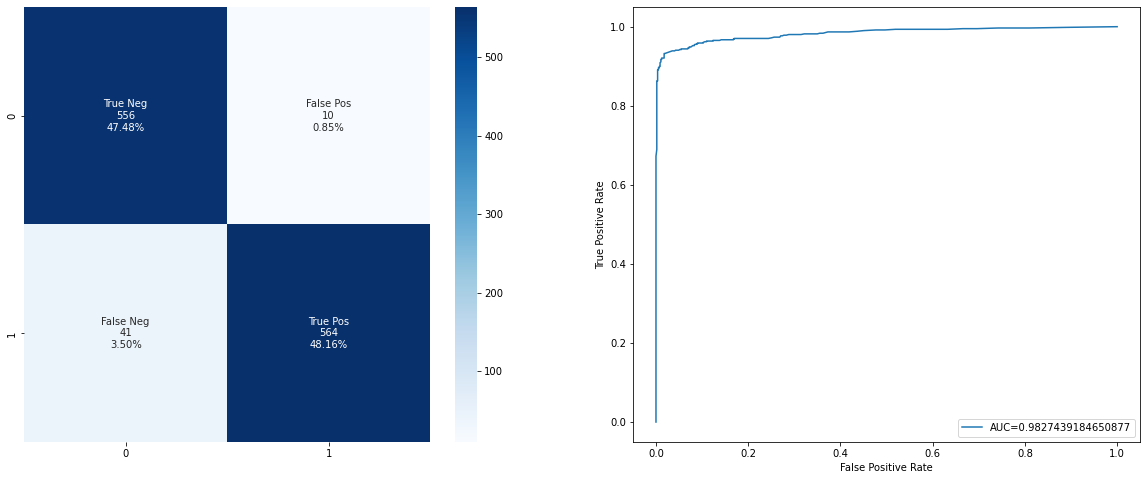

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       566
           1       0.98      0.93      0.96       605

    accuracy                           0.96      1171
   macro avg       0.96      0.96      0.96      1171
weighted avg       0.96      0.96      0.96      1171



In [62]:
top_features = ['default_protein_max',
 'lingo3_max',
 'TFIDF_simmat_mean',
 'target_align_score_max',
 'TF_simmat_max',
 'TFIDF_simmat_max',
 'count_target',
 'adj_lingo5_mean',
 'lingo3_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Enzyme 1:1 top_features'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [100]:
columns = ['Model','AUPRC', 'AUROC', 'Accuracy']
metricTableClassification = pd.DataFrame(columns=columns)
metricTableClassification


,Model,AUPRC,AUROC,Accuracy


In [101]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, auc
import pandas as pd

Results of KNN

 KNN ...................................

Accuracy: 0.8727583262169086
F1-Score: 0.8738357324301439
AUPRC: 0.9210383744422161
AUROC: 0.9289621236457086
PrecisionClass0: 0.8504201680672269
RecallClass0: 0.8939929328621908
PrecisionClass1: 0.8958333333333334
RecallClass1: 0.8528925619834711


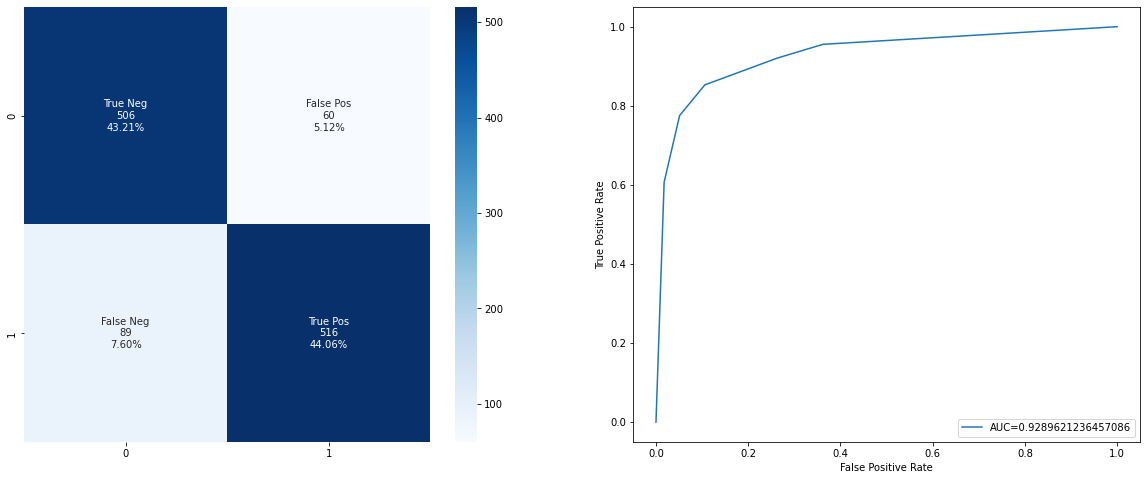

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       566
           1       0.90      0.85      0.87       605

    accuracy                           0.87      1171
   macro avg       0.87      0.87      0.87      1171
weighted avg       0.87      0.87      0.87      1171

Results of Logistic Regression

 Logistic Regression ...................................

Accuracy: 0.9197267292912041
F1-Score: 0.9188255613126081
AUPRC: 0.9725810160608013
AUROC: 0.9604853546710277
PrecisionClass0: 0.8818770226537217
RecallClass0: 0.9628975265017667
PrecisionClass1: 0.9620253164556962
RecallClass1: 0.8793388429752066


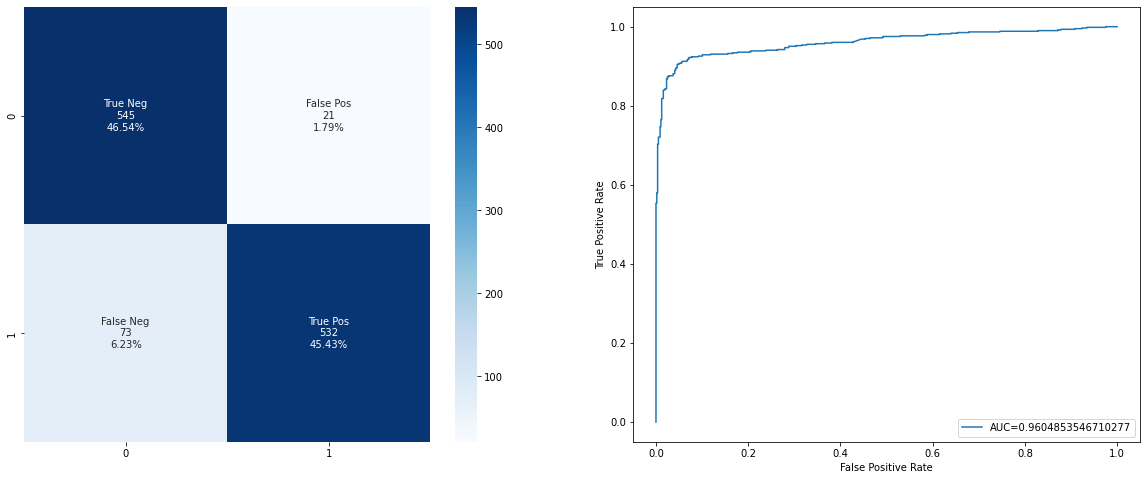

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       566
           1       0.96      0.88      0.92       605

    accuracy                           0.92      1171
   macro avg       0.92      0.92      0.92      1171
weighted avg       0.92      0.92      0.92      1171

Results of MLP Model 1

 MLP Model 1 ...................................

Accuracy: 0.9265584970111016
F1-Score: 0.9249563699825479
AUPRC: 0.9784042910180709
AUROC: 0.9725841777881611
PrecisionClass0: 0.8809523809523809
RecallClass0: 0.980565371024735
PrecisionClass1: 0.9796672828096118
RecallClass1: 0.8760330578512396


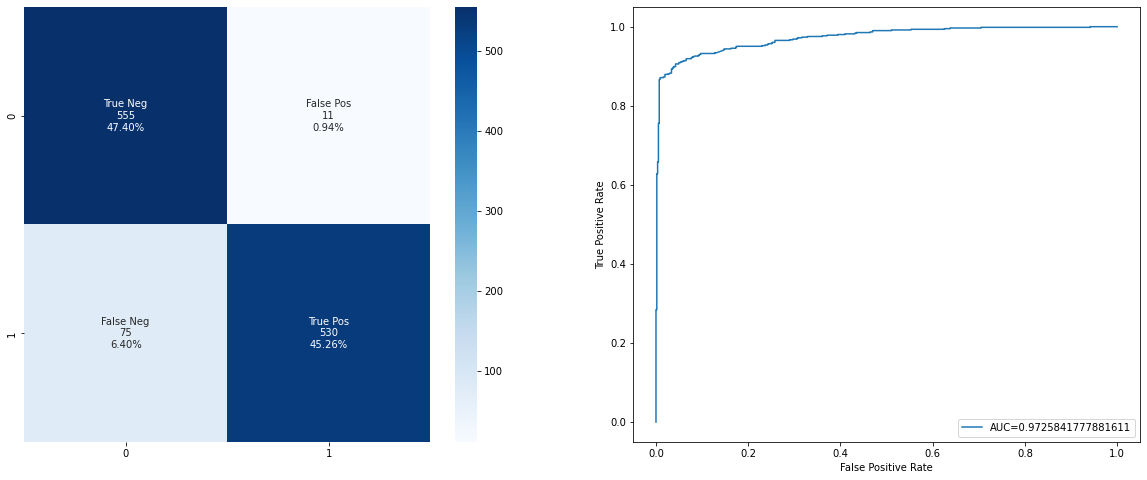

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       566
           1       0.98      0.88      0.92       605

    accuracy                           0.93      1171
   macro avg       0.93      0.93      0.93      1171
weighted avg       0.93      0.93      0.93      1171

Results of MLP Model 2

 MLP Model 2 ...................................

Accuracy: 0.9265584970111016
F1-Score: 0.9259896729776248
AUPRC: 0.9752023031584316
AUROC: 0.9735128347399469
PrecisionClass0: 0.8908794788273615
RecallClass0: 0.9664310954063604
PrecisionClass1: 0.9658886894075404
RecallClass1: 0.8892561983471075


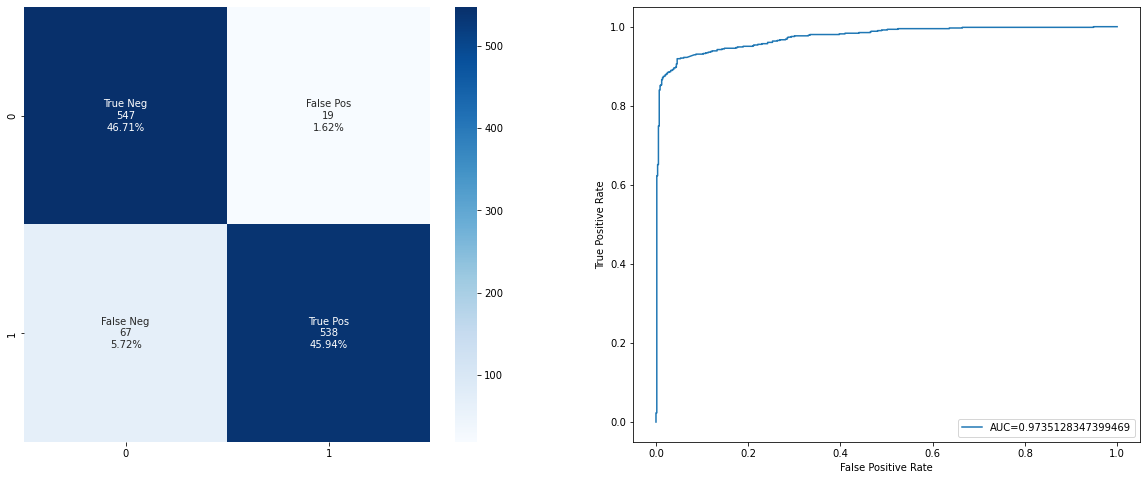

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       566
           1       0.97      0.89      0.93       605

    accuracy                           0.93      1171
   macro avg       0.93      0.93      0.93      1171
weighted avg       0.93      0.93      0.93      1171

Results of Decision Tree

 Decision Tree ...................................

Accuracy: 0.9086251067463706
F1-Score: 0.9107589658048374
AUPRC: 0.8825108329691156
AUROC: 0.9110869374762726
PrecisionClass0: 0.8977469670710572
RecallClass0: 0.9151943462897526
PrecisionClass1: 0.9191919191919192
RecallClass1: 0.9024793388429752


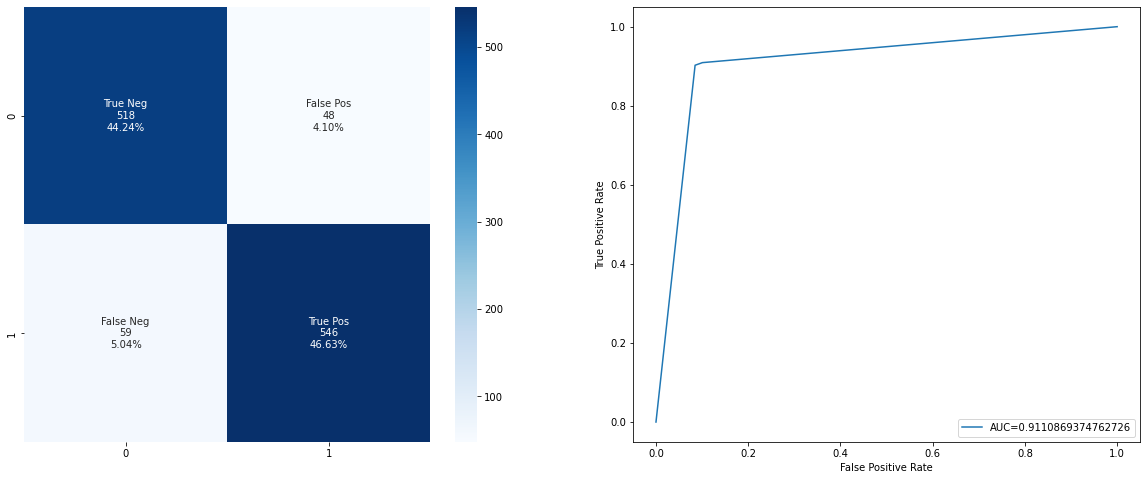

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       566
           1       0.92      0.90      0.91       605

    accuracy                           0.91      1171
   macro avg       0.91      0.91      0.91      1171
weighted avg       0.91      0.91      0.91      1171

Results of Random Forest

 Random Forest ...................................

Accuracy: 0.9538855678906917
F1-Score: 0.9541595925297114
AUPRC: 0.9851415718404966
AUROC: 0.9819787985865726
PrecisionClass0: 0.9280936454849499
RecallClass0: 0.980565371024735
PrecisionClass1: 0.9808027923211169
RecallClass1: 0.9289256198347108


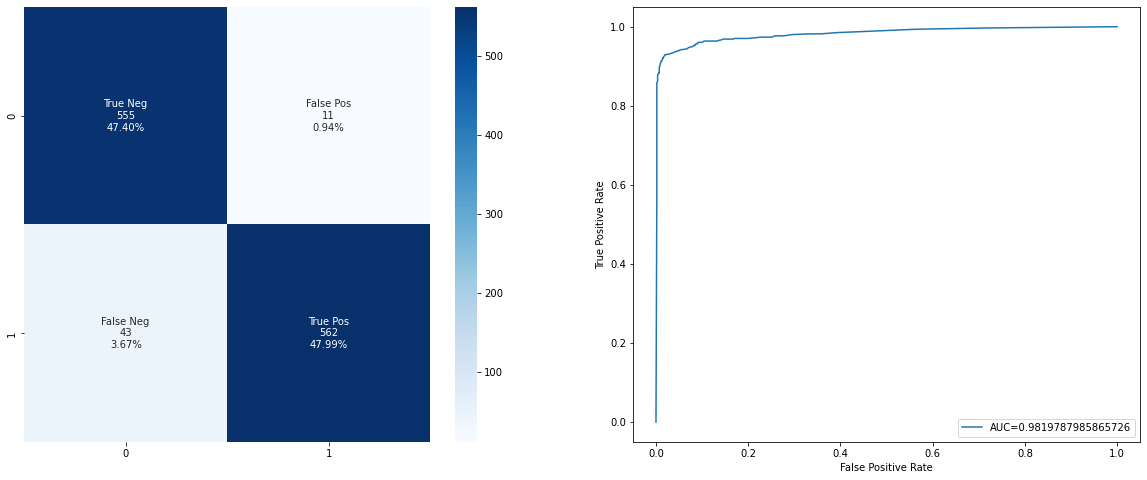

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       566
           1       0.98      0.93      0.95       605

    accuracy                           0.95      1171
   macro avg       0.95      0.95      0.95      1171
weighted avg       0.96      0.95      0.95      1171



,Model,AUPRC,AUROC,Accuracy
0,KNN,0.921038,0.928962,0.872758
1,Logistic Regression,0.972581,0.960485,0.919727
2,MLP Model 1,0.978404,0.972584,0.926558
3,MLP Model 2,0.975202,0.973513,0.926558
4,Decision Tree,0.882511,0.911087,0.908625
5,Random Forest,0.985142,0.981979,0.953886


In [102]:
top_features = ['default_protein_max',
 'lingo3_max',
 'TFIDF_simmat_mean',
 'target_align_score_max',
 'TF_simmat_max',
 'TFIDF_simmat_max',
 'count_target',
 'adj_lingo5_mean',
 'lingo3_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)

# List of models to evaluate
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP Model 1': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42),
    'MLP Model 2': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42)
}




for model_name, model in models.items():
    print(f"Results of {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    auprc, auc_score, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, tp = confusionMat_v2(y_test, y_pred, y_prob,model_name)
    
    # Save results
    df_list = [model_name, auprc, auc_score, accuracy]
    metricTableClassification.loc[len(metricTableClassification)] = df_list

metricTableClassification

# 

<a name="3.2"></a>
### Ratio 1:5
- [Evaluatuin](#3.2.0)
- [Feature Selection](#3.2.1)

In [63]:
# Generate a DataFrame with 2926 random combinations
num_combinations = len(mapping) * 5
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all

,index,Protein,Drug,Label
0,0,hsa10,D00002,1
1,1,hsa107,D00002,1
2,2,hsa108,D00002,1
3,3,hsa109,D00002,1
4,4,hsa111,D00002,1
...,...,...,...,...
17551,17551,hsa270,D05353,0
17552,17552,hsa91039,D00332,0
17553,17553,hsa7172,D02580,0
17554,17554,hsa8556,D02321,0


In [64]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [65]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                    'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,             
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])

for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    default_protein_max = 0
    default_compound_max = 0


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
       
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])

    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']

df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']

df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']



df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']

df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']


df_scores

17556it [13:08, 22.27it/s]                                                                                                                                 


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00002,hsa10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00002,hsa107,0.483871,0.437935,0.15508,0.1391,0.39847,0.360495,0.46062,...,0.72099,0.80459,1.2024,0.697825,0.760683,0.561813,0.50676,0.502185,0.04422,1.06594
2,2,D00002,hsa108,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,D00002,hsa109,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,D00002,hsa111,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17551,17551,D05353,hsa270,0.088,0.088,0.05871,0.05871,0.17281,0.17281,0.00808,...,0.17281,0.00808,0.02193,0.075868,0.258621,0.067633,0.0122,0.0,0.03704,0.49447
17552,17552,D00332,hsa91039,0.016949,0.016949,0.13287,0.13287,0.37895,0.37895,0.0,...,0.37895,0.0,0.0,0.0,0.45,0.071429,0.0,0.0,0.09091,0.40833
17553,17553,D02580,hsa7172,0.181818,0.181818,0.09329,0.09329,0.23269,0.23269,0.02273,...,0.23269,0.02273,0.17039,0.122549,0.307692,0.161111,0.07843,0.027778,0.07692,0.54815
17554,17554,D02321,hsa8556,0.053812,0.047812,0.01388,0.013,0.03933,0.03688,0.00059,...,0.07376,0.001,0.0569,0.029841,0.196471,0.027822,0.00552,0.0,0.01541,0.51564


In [66]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_default_protein_max', 'adj_default_compound_max',
       'adj_HLCS_max', 'adj_NLCS_max', 'adj_TFIDF_simmat_max',
       'adj_TF_simmat_max', 'adj_complingo_max', 'adj_edit_max',
       'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_comptfidf_max',
       'adj_comptfidf_mean', 'adj_smile_mean', 'adj_sequence_mean',
       'adj_kmer1_mean', 'adj_kmer2_mean', 'adj_kmer3_mean', 'adj_kmer4_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

Results of  Enzyme 1:5

 RandomForest ...................................

Accuracy: 0.974373576309795
F1-Score: 0.9174311926605506
AUPRC: 0.9609760878416447
AUROC: 0.9813455325177978
PrecisionClass0: 0.9756260434056762
RecallClass0: 0.9942157196325281
PrecisionClass1: 0.9671179883945842
RecallClass1: 0.8726003490401396


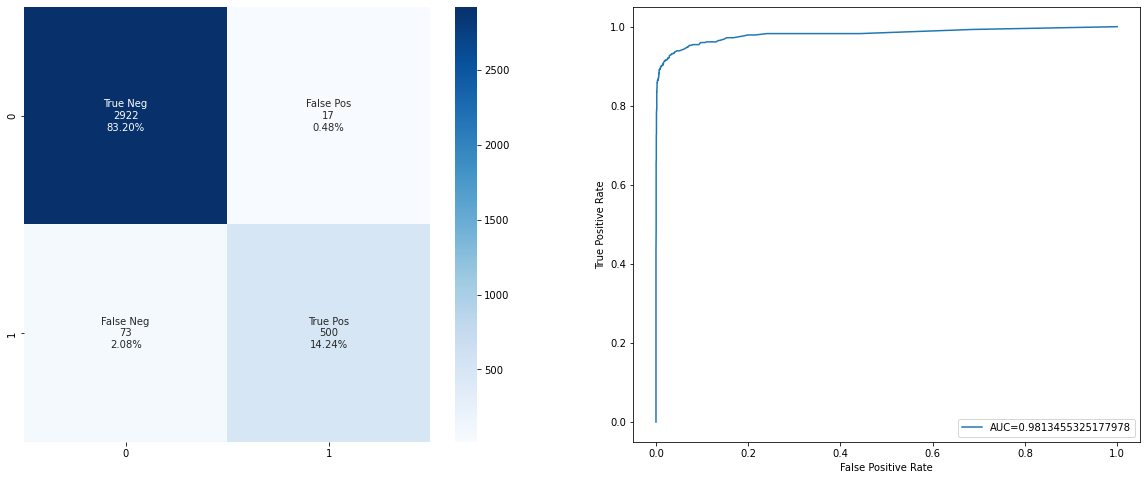

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2939
           1       0.97      0.87      0.92       573

    accuracy                           0.97      3512
   macro avg       0.97      0.93      0.95      3512
weighted avg       0.97      0.97      0.97      3512



In [67]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Enzyme 1:5'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

<a name="3.2.1"></a>
**Feature Selection**

In [68]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: kmer4_max - Accuracy: 0.9484624145785877
Added feature: kmer3_max - Accuracy: 0.9604214123006833
Added feature: default_compound_max - Accuracy: 0.9675398633257403
Added feature: adj_default_protein_max - Accuracy: 0.9726651480637813
Added feature: default_protein_mean - Accuracy: 0.9746583143507973
Added feature: adj_TFIDF_simmat_mean - Accuracy: 0.9757972665148064
Selected features: ['kmer4_max', 'kmer3_max', 'default_compound_max', 'adj_default_protein_max', 'default_protein_mean', 'adj_TFIDF_simmat_mean']
Final Accuracy with selected features: 0.9757972665148064


Results of  Enzyme 1:5 top_features

 RandomForest ...................................

Accuracy: 0.9757972665148064
F1-Score: 0.9218031278748849
AUPRC: 0.9452325766273488
AUROC: 0.9714933728096663
PrecisionClass0: 0.9759839893262174
RecallClass0: 0.9955767267778156
PrecisionClass1: 0.9747081712062257
RecallClass1: 0.8743455497382199


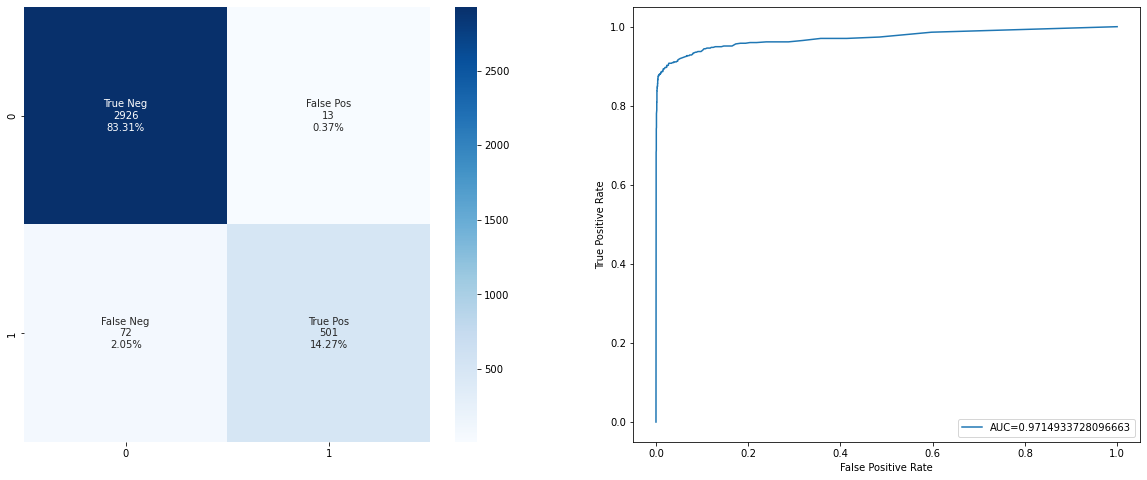

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2939
           1       0.97      0.87      0.92       573

    accuracy                           0.98      3512
   macro avg       0.98      0.93      0.95      3512
weighted avg       0.98      0.98      0.98      3512



In [69]:
top_features = ['kmer4_max', 'kmer3_max',
                'default_compound_max', 'adj_default_protein_max', 
                'default_protein_mean', 'adj_TFIDF_simmat_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Enzyme 1:5 top_features'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [71]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


In [74]:
selected_features = []
best_aupr = 0  # Start with zero as the best AUPR

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred_proba = rf.predict_proba(X_test[temp_features])[:, 1]

        # Calculate precision-recall curve and AUPR
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        current_aupr = auc(recall, precision)

        # If this model is better, select this feature
        if current_aupr > best_aupr:
            best_aupr = current_aupr
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - AUPR: {best_aupr}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final_proba = rf_final.predict_proba(X_test[selected_features])[:, 1]

# Calculate final precision-recall curve and AUPR
precision_final, recall_final, _ = precision_recall_curve(y_test, y_pred_final_proba)
final_aupr = auc(recall_final, precision_final)
print(f"Final AUPR with selected features: {final_aupr}")

Added feature: default_protein_max - AUPR: 0.8774514922326628
Added feature: lingo3_max - AUPR: 0.9244729054211507
Added feature: adj_default_protein_mean - AUPR: 0.944018557898741
Added feature: adj_edit_mean - AUPR: 0.9528711689497225


KeyboardInterrupt: 

In [75]:
selected_features

['default_protein_max',
 'lingo3_max',
 'adj_default_protein_mean',
 'adj_edit_mean']

Results of  Enzyme 1:5 top_features2

 RandomForest ...................................

Accuracy: 0.9718109339407744
F1-Score: 0.9099181073703367
AUPRC: 0.9504925950988564
AUROC: 0.9786852742233442
PrecisionClass0: 0.9755525787006029
RecallClass0: 0.9911534535556311
PrecisionClass1: 0.9505703422053232
RecallClass1: 0.8726003490401396


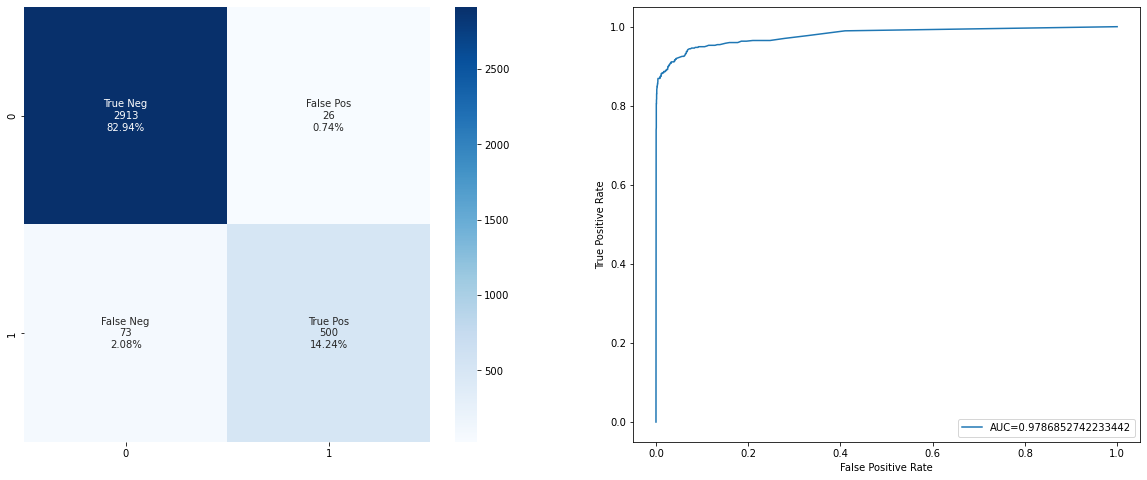

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2939
           1       0.95      0.87      0.91       573

    accuracy                           0.97      3512
   macro avg       0.96      0.93      0.95      3512
weighted avg       0.97      0.97      0.97      3512



In [76]:
top_features = ['default_protein_max',
 'lingo3_max',
 'adj_default_protein_mean',
 'adj_edit_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Enzyme 1:5 top_features2'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

# 

<a name="3.3"></a>
### Ratio 1:10
- [Evaluatuin](#3.3.0)
- [Feature Selection](#3.3.1)

In [77]:
# Generate a DataFrame with 2926 random combinations
num_combinations = len(mapping) * 10
df_random = generate_random_combinations(num_combinations, all_drugs, all_targets, mapping)
# Concatenate original DataFrame with the random combinations
mapping_all = pd.concat([mapping.assign(Label=1), df_random], ignore_index=True)
mapping_all = mapping_all.reset_index()
mapping_all

,index,Protein,Drug,Label
0,0,hsa10,D00002,1
1,1,hsa107,D00002,1
2,2,hsa108,D00002,1
3,3,hsa109,D00002,1
4,4,hsa111,D00002,1
...,...,...,...,...
32181,32181,hsa5537,D00252,0
32182,32182,hsa766,D02559,0
32183,32183,hsa5595,D00043,0
32184,32184,hsa94,D03776,0


In [78]:
#Split Dataset
train_mapping, test_mapping = train_test_split(mapping_all, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [79]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                    'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,             
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])

for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    default_protein_max = 0
    default_compound_max = 0


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
       
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])

    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']

df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']

df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']



df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']

df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']


df_scores

32186it [29:34, 18.14it/s]                                                                                                                                 


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00002,hsa10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,D00002,hsa107,0.483871,0.437935,0.15508,0.1391,0.39847,0.360495,0.46062,...,0.72099,0.80459,1.2024,0.697825,0.760683,0.561813,0.50676,0.502185,0.04422,1.06594
2,2,D00002,hsa108,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,D00002,hsa109,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,D00002,hsa111,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32181,32181,D00252,hsa5537,0.040201,0.031421,0.01346,0.01273,0.0308,0.028185,0.02237,...,0.05637,0.02428,0.18149,0.028085,0.136945,0.061099,0.01934,0.010933,0.01615,0.55525
32182,32182,D02559,hsa766,0.191176,0.108614,0.1104,0.076674,0.31373,0.213102,0.09245,...,1.91792,0.11301,0.39126,0.754622,2.272811,0.505826,0.1971,0.073465,0.4759,3.89887
32183,32183,D00043,hsa5595,0.045113,0.03802,0.05657,0.04734,0.15556,0.128485,0.01853,...,0.25697,0.01899,0.14872,0.079837,0.377152,0.11024,0.05385,0.0,0.04712,0.53056
32184,32184,D03776,hsa94,0.100559,0.100559,0.06279,0.06279,0.18033,0.18033,0.04431,...,0.18033,0.04431,0.16044,0.128878,0.205479,0.148208,0.06728,0.045833,0.02273,0.43543


In [80]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_default_protein_max', 'adj_default_compound_max',
       'adj_HLCS_max', 'adj_NLCS_max', 'adj_TFIDF_simmat_max',
       'adj_TF_simmat_max', 'adj_complingo_max', 'adj_edit_max',
       'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_comptfidf_max',
       'adj_comptfidf_mean', 'adj_smile_mean', 'adj_sequence_mean',
       'adj_kmer1_mean', 'adj_kmer2_mean', 'adj_kmer3_mean', 'adj_kmer4_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

Results of  Enzyme 1:10

 RandomForest ...................................

Accuracy: 0.9883504193849021
F1-Score: 0.9295774647887324
AUPRC: 0.9597873643385249
AUROC: 0.9857825912000764
PrecisionClass0: 0.9897115871141845
RecallClass0: 0.9976198571914315
PrecisionClass1: 0.9724950884086444
RecallClass1: 0.8902877697841727


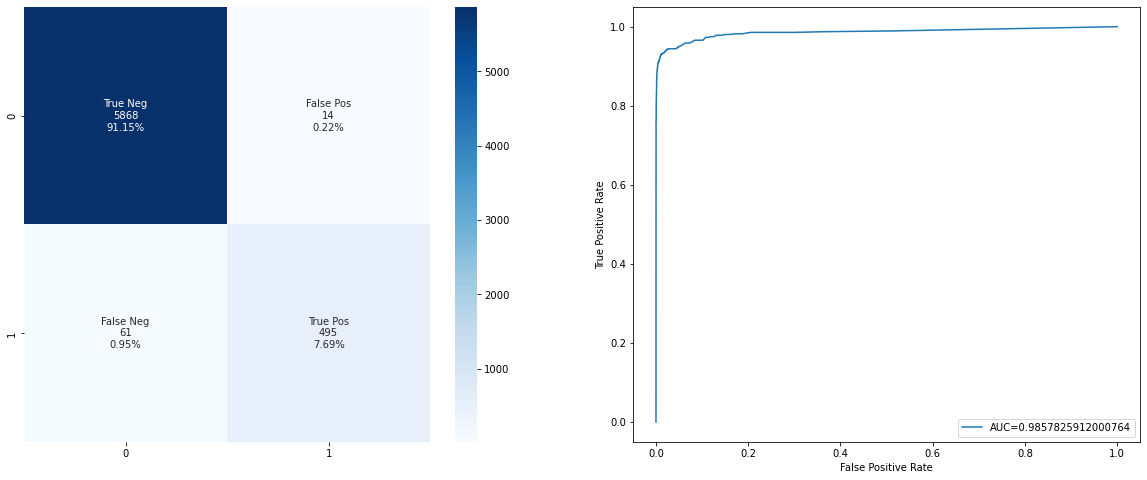

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5882
           1       0.97      0.89      0.93       556

    accuracy                           0.99      6438
   macro avg       0.98      0.94      0.96      6438
weighted avg       0.99      0.99      0.99      6438



In [81]:
# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Enzyme 1:10'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

<a name="3.3.1"></a>
**Feature Selection**

In [82]:
selected_features = []
best_accuracy = 0  # Start with zero as the best accuracy

# Assuming 'features' is a list of feature names
all_features = list(features)
remaining_features = all_features.copy()

# Iteratively add features
while remaining_features:
    feature_to_add = None
    for feature in remaining_features:
        # Create a temporary list of selected features
        temp_features = selected_features + [feature]

        # Train the model
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train[temp_features], y_train)
        y_pred = rf.predict(X_test[temp_features])

        # Evaluate the model using accuracy
        current_accuracy = accuracy_score(y_test, y_pred)

        # If this model is better, select this feature
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            feature_to_add = feature

    if feature_to_add is not None:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        print(f"Added feature: {feature_to_add} - Accuracy: {best_accuracy}")
    else:
        break

print("Selected features:", selected_features)

# Final model training and evaluation with selected features
rf_final = RandomForestClassifier(n_estimators=500, random_state=42)
rf_final.fit(X_train[selected_features], y_train)
y_pred_final = rf_final.predict(X_test[selected_features])

# Evaluate the final model using accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with selected features: {final_accuracy}")

Added feature: default_protein_max - Accuracy: 0.9740602671637154
Added feature: default_protein_mean - Accuracy: 0.9808946877912396
Added feature: comptfidf_max - Accuracy: 0.9849332090711401
Added feature: adj_NLCS_mean - Accuracy: 0.9872631251941597
Added feature: adj_kmer4_max - Accuracy: 0.9880397639018329
Added feature: adj_complingo_mean - Accuracy: 0.9885057471264368


KeyboardInterrupt: 

In [83]:
selected_features

['default_protein_max',
 'default_protein_mean',
 'comptfidf_max',
 'adj_NLCS_mean',
 'adj_kmer4_max',
 'adj_complingo_mean']

Results of  Enzyme 1:10 top_features

 RandomForest ...................................

Accuracy: 0.9885057471264368
F1-Score: 0.9309701492537314
AUPRC: 0.9582304628710461
AUROC: 0.9885423521094718
PrecisionClass0: 0.9903748733535968
RecallClass0: 0.9971098265895953
PrecisionClass1: 0.9670542635658915
RecallClass1: 0.8974820143884892


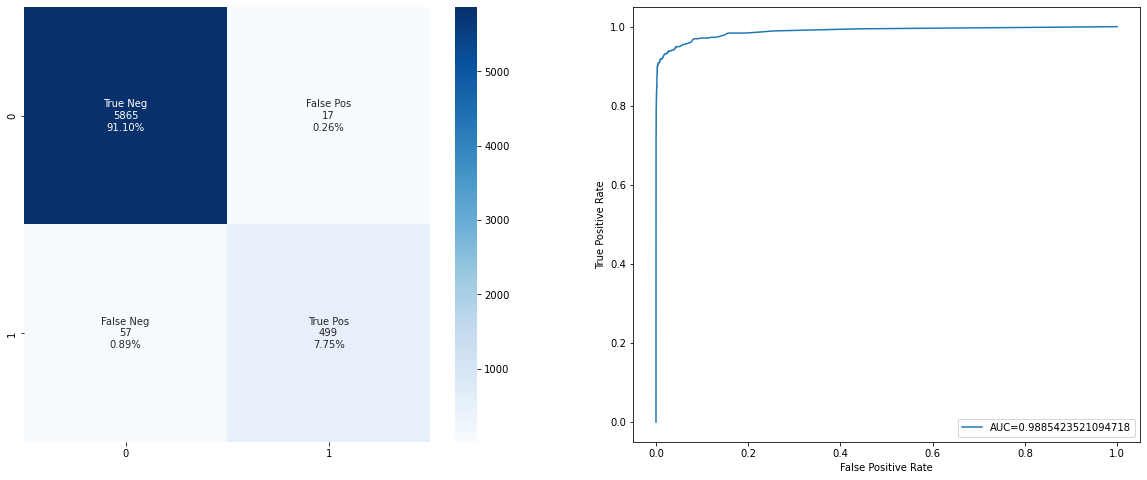

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5882
           1       0.97      0.90      0.93       556

    accuracy                           0.99      6438
   macro avg       0.98      0.95      0.96      6438
weighted avg       0.99      0.99      0.99      6438



In [84]:
top_features = ['default_protein_max',
 'default_protein_mean',
 'comptfidf_max',
 'adj_NLCS_mean',
 'adj_kmer4_max',
 'adj_complingo_mean']
# Split into X_train, y_train, X_test, y_test
X_train = train[top_features]
y_train = train['target']
X_test = test[top_features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'Enzyme 1:10 top_features'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [85]:
features_ENZYME_10 = ['default_protein_max', 'default_protein_mean','comptfidf_max',
                        'adj_NLCS_mean','adj_kmer4_max','adj_complingo_mean']

features_ENZYME_5 = ['default_protein_max','lingo3_max','adj_default_protein_mean','adj_edit_mean']

features_ENZYME_1 = ['default_protein_max', 'lingo3_max', 'TFIDF_simmat_mean','target_align_score_max',
                     'TF_simmat_max','TFIDF_simmat_max','count_target','adj_lingo5_mean','lingo3_mean']

In [86]:
features_GPCR_10 = ['default_protein_max',
               'adj_kmer3_mean', 'comptfidf_max', 'comptfidf_mean', 'adj_default_compound_mean', 'adj_NT_mean']

features_GPCR_5 = ['default_protein_max', 'default_compound_max', 
               'adj_kmer4_mean', 'adj_default_compound_mean',
               'lingo4_mean', 'adj_kmer2_max']

features_GPCR_1 = ['default_protein_max', 'adj_smile_mean', 'adj_kmer3_max']

In [87]:
features_NR_10 = ['TFIDF_simmat_max', 'adj_kmer3_max', 'NT_mean', 'NLCS_max']

features_NR_5 = ['adj_kmer3_mean', 'smifp34Man_max', 'HLCS_max', 'adj_default_protein_max', 'smifp38Tan_max']

features_NR_1 = ['kmer4_mean', 'smifp38Tan_max']

In [88]:
features_IC_10 = ['default_protein_max', 'adj_kmer3_mean', 
               'kmer2_max', 'TFIDF_simmat_max', 
               'comptfidf_mean', 'default_protein_mean', 'target_align_score_max', 'target_align_score_mean']

features_IC_5 = ['kmer4_max', 'kmer4_mean', 'edit_max', 'smifp38Tan_max', 
               'adj_sequence_max', 'default_compound_mean', 'default_protein_mean', 'lingo5_max', 'smile_score_mean', 
               'default_protein_max', 'target_align_score_mean', 'TF_simmat_mean', 'adj_smile_mean']

features_IC_1 = ['kmer6_max', 'lingo5_max', 'smifp34Tan_max', 'adj_kmer2_max', 'NLCS_max', 'comptfidf_mean']

In [89]:
from collections import Counter

# Combine all feature lists into one
all_features = features_IC_10 + features_IC_5 + features_IC_1 + features_NR_10 + features_NR_5 + features_NR_1 + features_GPCR_10 + features_GPCR_5 + features_GPCR_1 + features_ENZYME_10 + features_ENZYME_5 + features_ENZYME_1

# Count frequency of each feature
feature_counts = Counter(all_features)
feature_counts

Counter({'default_protein_max': 8,
         'adj_kmer3_mean': 3,
         'kmer2_max': 1,
         'TFIDF_simmat_max': 3,
         'comptfidf_mean': 3,
         'default_protein_mean': 3,
         'target_align_score_max': 2,
         'target_align_score_mean': 2,
         'kmer4_max': 1,
         'kmer4_mean': 2,
         'edit_max': 1,
         'smifp38Tan_max': 3,
         'adj_sequence_max': 1,
         'default_compound_mean': 1,
         'lingo5_max': 2,
         'smile_score_mean': 1,
         'TF_simmat_mean': 1,
         'adj_smile_mean': 2,
         'kmer6_max': 1,
         'smifp34Tan_max': 1,
         'adj_kmer2_max': 2,
         'NLCS_max': 2,
         'adj_kmer3_max': 2,
         'NT_mean': 1,
         'smifp34Man_max': 1,
         'HLCS_max': 1,
         'adj_default_protein_max': 1,
         'comptfidf_max': 2,
         'adj_default_compound_mean': 2,
         'adj_NT_mean': 1,
         'default_compound_max': 1,
         'adj_kmer4_mean': 1,
         'lingo4_mean': 1,


In [90]:
len(set(all_features))

44

## Case Study

In [103]:
mapping

,Protein,Drug
0,hsa10,D00002
1,hsa107,D00002
2,hsa108,D00002
3,hsa109,D00002
4,hsa111,D00002
...,...,...
2921,hsa1576,D05353
2922,hsa476,D05353
2923,hsa30,D05407
2924,hsa4129,D05458


In [104]:
from itertools import product
# Extract unique proteins and drugs
unique_proteins = mapping['Protein'].unique()
unique_drugs = mapping['Drug'].unique()

# Generate all possible combinations
all_combinations = list(product(unique_proteins, unique_drugs))

# Check if each combination is in the original DataFrame
combination_labels = [
    (protein, drug, 1 if not mapping[(mapping['Protein'] == protein) & (mapping['Drug'] == drug)].empty else 0)
    for protein, drug in all_combinations
]

# Create the new DataFrame
new_df = pd.DataFrame(combination_labels, columns=['Protein', 'Drug', 'Label'])
new_df

,Protein,Drug,Label
0,hsa10,D00002,1
1,hsa10,D00005,0
2,hsa10,D00007,0
3,hsa10,D00014,0
4,hsa10,D00018,0
...,...,...,...
295475,hsa5538,D05341,1
295476,hsa5538,D05353,0
295477,hsa5538,D05407,0
295478,hsa5538,D05458,0


In [105]:
new_df['Label'].value_counts()

0    292554
1      2926
Name: Label, dtype: int64

In [106]:
new_df = new_df.reset_index()

In [107]:
unknown  = new_df[new_df['Label'] == 0]
positive = new_df[new_df['Label'] == 1]
#Negative
negative_df = unknown.sample(n=2926, replace=True, random_state=1)
concatenated_df = pd.concat([positive, negative_df], ignore_index=True)
#Split Dataset
train_mapping, test_mapping = train_test_split(concatenated_df, test_size=0.2, random_state=42)
train_one = train_mapping[train_mapping['Label']==1]
#save their index
index_train = train_mapping['index'].tolist()
index_test  = test_mapping['index'].tolist()

In [108]:
#Building up an empty dataframe for MiRAGE scores for each drug_disease pair 
#Note: Obviously the number of similarities(j) could be different in this case j=2 and total featueres will be 6(2j+2)
df_scores = pd.DataFrame(columns=['index','drugID', 'targetID', 
                                  #Smile
                                  'smile_score_max','smile_score_mean',
                                    'HLCS_max' , 'HLCS_mean',      
                                    "NLCS_max" , "NLCS_mean" , 
                                    "TFIDF_simmat_max" , "TFIDF_simmat_mean" ,
                                    "TF_simmat_max" , "TF_simmat_mean" ,
                                    "complingo_max" , "complingo_mean" ,   
                                    "comptfidf_max" , "comptfidf_mean" ,    
                                    "edit_max" , "edit_mean" ,       
                                    "lingo3_max" , "lingo3_mean" ,       
                                    "lingo4_max" , "lingo4_mean" ,       
                                    "lingo5_max" , "lingo5_mean" ,   
                                    "smifp34Man_max" , "smifp34Man_mean" ,             
                                    "smifp34Tan_max" , "smifp34Tan_mean" ,             
                                    "smifp38Man_max" , "smifp38Man_mean" ,             
                                    "smifp38Tan_max" , "smifp38Tan_mean" ,             
                                    "substring_max" , "substring_mean" ,             
                                  #Sequence
                                  'target_align_score_max','target_align_score_mean',
                                  #Kmer4
                                  'kmer4_max','kmer4_mean',
                                  #Kmer3
                                  'kmer3_max','kmer3_mean',
                                  #Kmer2
                                  'kmer2_max','kmer2_mean',
                                  #Kmer1
                                  'kmer1_max','kmer1_mean',
                                  #Default Protein
                                  "default_protein_max","default_protein_mean",
                                  #Default Compound structure 
                                  "default_compound_max","default_compound_mean",
                                  #Counts
                                  'count_drug','count_target','target'])

for index, row in tqdm(mapping_all.iterrows(), total=len(mapping)):
    index_row = row['index']
    drug_test = row['Drug']
    target_test = row['Protein']
    associated_values = row['Label']
    
    #Extract As and Bd From train mapping
    target_list_one = train_one[train_one['Drug'] == drug_test]['Protein'].tolist()
    drug_list_one = train_one[train_one['Protein'] == target_test]['Drug'].tolist()

    # We diligently calculate scores even for single instances within our training mappings.
    target_list_one = [item for item in target_list_one if item != target_test]
    drug_list_one = [item for item in drug_list_one if item != drug_test]

    #Set default values to zero
    smile_score_max = 0
    target_align_score_max = 0
    kmer4_max = 0
    kmer3_max = 0
    kmer2_max = 0
    kmer1_max = 0
    NT_max = 0
    default_protein_max = 0
    default_compound_max = 0
    
    HLCS_max = 0
    NLCS_max = 0
    TFIDF_simmat_max = 0
    TF_simmat_max = 0
    complingo_max = 0
    comptfidf_max = 0
    edit_max = 0
    lingo3_max = 0
    lingo4_max = 0
    lingo5_max = 0
    smifp34Man_max = 0
    smifp34Tan_max = 0
    smifp38Man_max = 0
    smifp38Tan_max = 0
    substring_max = 0

    smile_score_mean = 0
    target_align_score_mean = 0
    kmer4_mean = 0
    kmer3_mean = 0
    kmer2_mean = 0
    kmer1_mean = 0
    NT_mean = 0
    default_protein_mean = 0
    default_compound_mean = 0
    
    HLCS_mean = 0
    NLCS_mean = 0
    TFIDF_simmat_mean = 0
    TF_simmat_mean = 0
    complingo_mean = 0
    comptfidf_mean = 0
    edit_mean = 0
    lingo3_mean = 0
    lingo4_mean = 0
    lingo5_mean = 0
    smifp34Man_mean = 0
    smifp34Tan_mean = 0
    smifp38Man_mean = 0
    smifp38Tan_mean = 0
    substring_mean = 0
    default_protein_max = 0
    default_compound_max = 0


    # Compute the maximum similarity as MiRAGE score
    if drug_list_one:
        smile_score_max = max(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        smile_score_mean = mean(sim_SMILE[sim_SMILE['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        #Default Compound 
        default_compound_max  = max(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        default_compound_mean = mean(default_compound[default_compound['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
       
        #SIMMAT
        HLCS_max  = max(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        HLCS_mean = mean(HLCS_simmat_dc[HLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        NLCS_max  = max(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        NLCS_mean = mean(NLCS_simmat_dc[NLCS_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
                         
        TFIDF_simmat_max  = max(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TFIDF_simmat_mean = mean(TFIDF_simmat_simmat_dc[TFIDF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        
        TF_simmat_max  = max(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        TF_simmat_mean = mean(TF_simmat_simmat_dc[TF_simmat_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        complingo_max  = max(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        complingo_mean = mean(complingo4_simmat_dc[complingo4_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        
        comptfidf_max   = max(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
        comptfidf_mean = mean(comptfidf_simmat_dc[comptfidf_simmat_dc['Unnamed: 0'] == drug_test][drug_list_one].values.tolist()[0])
      
        edit_max  = max(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        edit_mean = mean(edit_simmat_dc[edit_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0]) 
                 
        lingo3_max  = max(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo3_mean = mean(lingo3_simmat_dc[lingo3_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        lingo4_max  = max(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo4_mean = mean(lingo4_simmat_dc[lingo4_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
            
        lingo5_max  = max(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])
        lingo5_mean = mean(lingo5_simmat_dc[lingo5_simmat_dc['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp34Man_max  = max(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Man_mean = mean(smifp34Man[smifp34Man['data'] == drug_test][drug_list_one].values.tolist()[0])
                           
        smifp34Tan_max  = max(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp34Tan_mean = mean(smifp34Tan[smifp34Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
                              
        smifp38Man_max   = max(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Man_mean = mean(smifp38Man[smifp38Man['data'] == drug_test][drug_list_one].values.tolist()[0])

        smifp38Tan_max  = max(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])
        smifp38Tan_mean = mean(smifp38Tan[smifp38Tan['data'] == drug_test][drug_list_one].values.tolist()[0])

    if target_list_one:
        #Sequence
        target_align_score_max = max(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        target_align_score_mean = mean(seq_SIM[seq_SIM['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER4
        kmer4_max = max(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer4_mean = mean(kmer_4_similarity[kmer_4_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER3
        kmer3_max = max(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer3_mean = mean(kmer_3_similarity[kmer_3_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER2
        kmer2_max = max(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer2_mean = mean(kmer_2_similarity[kmer_2_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #KMER1
        kmer1_max  = max(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        kmer1_mean = mean(kmer_1_similarity[kmer_1_similarity['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        #Default Protein 
        default_protein_max  = max(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())
        default_protein_mean = mean(default_protein[default_protein['Unnamed: 0'] == target_test][target_list_one].values.flatten())

        
    #Adding len of As and Bd and use them as two features
    count_drug = len(drug_list_one)
    count_target = len(target_list_one)





    #Filling the df 
    example_data = [index_row ,drug_test, target_test, 
                    #Smile
                    smile_score_max, smile_score_mean,
                    HLCS_max , HLCS_mean,      
                    NLCS_max , NLCS_mean, 
                    TFIDF_simmat_max , TFIDF_simmat_mean,
                    TF_simmat_max , TF_simmat_mean ,
                    complingo_max , complingo_mean ,   
                    comptfidf_max , comptfidf_mean ,    
                    edit_max , edit_mean ,       
                    lingo3_max , lingo3_mean ,       
                    lingo4_max , lingo4_mean ,       
                    lingo5_max , lingo5_mean ,   
                    smifp34Man_max , smifp34Man_mean ,             
                    smifp34Tan_max , smifp34Tan_mean ,             
                    smifp38Man_max , smifp38Man_mean ,             
                    smifp38Tan_max , smifp38Tan_mean ,             
                    substring_max ,  substring_mean ,   
                    #Sequence
                    target_align_score_max, target_align_score_mean, 
                    #Kmer4
                    kmer4_max, kmer4_mean,
                    #Kmer3
                    kmer3_max,kmer3_mean,
                    #Kmer2
                    kmer2_max,kmer2_mean,
                    #Kmer1
                    kmer1_max,kmer1_mean,
                    #Default Protein
                    default_protein_max ,default_protein_mean,
                    #Default Compound structure 
                    default_compound_max , default_compound_mean,
                    #Count
                    count_drug, count_target,associated_values]  




    # Add example data to the last row
    df_scores.loc[len(df_scores)] = example_data


df_scores['adj_smile_max']     = df_scores['count_drug']   * df_scores['smile_score_max']
df_scores['adj_sequence_max']  = df_scores['count_target'] * df_scores['target_align_score_max']
df_scores['adj_kmer1_max']     = df_scores['count_target'] * df_scores['kmer1_max']
df_scores['adj_kmer2_max']     = df_scores['count_target'] * df_scores['kmer2_max']
df_scores['adj_kmer3_max']     = df_scores['count_target'] * df_scores['kmer3_max']
df_scores['adj_kmer4_max']     = df_scores['count_target'] * df_scores['kmer4_max']
df_scores['adj_default_protein_max']     = df_scores['count_target'] * df_scores['default_protein_max']
df_scores['adj_default_compound_max']    = df_scores['count_drug'] * df_scores['default_compound_max']

df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_NLCS_max']              = df_scores['count_drug'] * df_scores['NLCS_max']
df_scores['adj_TFIDF_simmat_max']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_max']
df_scores['adj_TF_simmat_max']         = df_scores['count_drug'] * df_scores['TF_simmat_max']
df_scores['adj_complingo_max']         = df_scores['count_drug'] * df_scores['complingo_max']
df_scores['adj_edit_max']              = df_scores['count_drug'] * df_scores['edit_max']
df_scores['adj_lingo3_max']            = df_scores['count_drug'] * df_scores['lingo3_max']
df_scores['adj_lingo4_max']            = df_scores['count_drug'] * df_scores['lingo4_max']
df_scores['adj_lingo5_max']            = df_scores['count_drug'] * df_scores['lingo5_max']
df_scores['adj_smifp34Man_max']        = df_scores['count_drug'] * df_scores['smifp34Man_max']
df_scores['adj_smifp34Tan_max']        = df_scores['count_drug'] * df_scores['smifp34Tan_max']
df_scores['adj_HLCS_max']              = df_scores['count_drug'] * df_scores['HLCS_max']
df_scores['adj_comptfidf_max']         = df_scores['count_drug'] * df_scores['comptfidf_max']

df_scores['adj_comptfidf_mean']         = df_scores['count_drug'] * df_scores['comptfidf_mean']



df_scores['adj_smile_mean']     = df_scores['count_drug']   * df_scores['smile_score_mean']
df_scores['adj_sequence_mean']  = df_scores['count_target'] * df_scores['target_align_score_mean']
df_scores['adj_kmer1_mean']     = df_scores['count_target'] * df_scores['kmer1_mean']
df_scores['adj_kmer2_mean']     = df_scores['count_target'] * df_scores['kmer2_mean']
df_scores['adj_kmer3_mean']     = df_scores['count_target'] * df_scores['kmer3_mean']
df_scores['adj_kmer4_mean']     = df_scores['count_target'] * df_scores['kmer4_mean']
df_scores['adj_default_protein_mean']     = df_scores['count_target'] * df_scores['default_protein_mean']
df_scores['adj_default_compound_mean']    = df_scores['count_drug'] * df_scores['default_compound_mean']

df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']
df_scores['adj_NLCS_mean']              = df_scores['count_drug'] * df_scores['NLCS_mean']
df_scores['adj_TFIDF_simmat_mean']      = df_scores['count_drug'] * df_scores['TFIDF_simmat_mean']
df_scores['adj_TF_simmat_mean']         = df_scores['count_drug'] * df_scores['TF_simmat_mean']
df_scores['adj_complingo_mean']         = df_scores['count_drug'] * df_scores['complingo_mean']
df_scores['adj_edit_mean']              = df_scores['count_drug'] * df_scores['edit_mean']
df_scores['adj_lingo3_mean']            = df_scores['count_drug'] * df_scores['lingo3_mean']
df_scores['adj_lingo4_mean']            = df_scores['count_drug'] * df_scores['lingo4_mean']
df_scores['adj_lingo5_mean']            = df_scores['count_drug'] * df_scores['lingo5_mean']
df_scores['adj_smifp34Man_mean']        = df_scores['count_drug'] * df_scores['smifp34Man_mean']
df_scores['adj_smifp34Tan_mean']        = df_scores['count_drug'] * df_scores['smifp34Tan_mean']
df_scores['adj_HLCS_mean']              = df_scores['count_drug'] * df_scores['HLCS_mean']


df_scores

5852it [03:47, 25.72it/s]                                                                                                                                  


,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
0,0,D00002,hsa10,0.117318,0.117318,0.05556,0.05556,0.15385,0.153850,0.02793,...,0.15385,0.02793,0.17687,0.11741,0.230769,0.122358,0.07353,0.060345,0.01563,0.32328
1,1,D00002,hsa107,0.483871,0.437935,0.15508,0.13910,0.39847,0.360495,0.46062,...,0.72099,0.80459,1.2024,0.697825,0.760683,0.561813,0.50676,0.502185,0.04422,1.06594
2,2,D00002,hsa108,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,D00002,hsa109,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,D00002,hsa111,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,5847,D03720,hsa64902,0.015748,0.015748,0.02985,0.02985,0.08224,0.082240,0.00000,...,0.08224,0.0,0.0,0.011111,0.140625,0.018182,0.0,0.0,0.02174,0.34259
5848,5848,D00667,hsa79799,0.169643,0.169643,0.06775,0.06775,0.19512,0.195120,0.16687,...,0.19512,0.16687,0.33083,0.218914,0.330579,0.196322,0.13116,0.077778,0.02564,0.41964
5849,5849,D00401,hsa8192,0.022222,0.022222,0.00762,0.00762,0.01538,0.015380,0.00000,...,0.01538,0.0,0.0,0.029412,0.1,0.0,0.0,0.0,0.04167,0.10714
5850,5850,D00593,hsa635,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
train = df_scores[df_scores['index'].isin(index_train)]
test  = df_scores[df_scores['index'].isin(index_test)]

Results of  NuclearReceptor 1:5

 RandomForest ...................................

Accuracy: 0.8666666666666667
F1-Score: 0.7499999999999999
AUPRC: 1.0
AUROC: 1.0
PrecisionClass0: 1.0
RecallClass0: 0.8333333333333334
PrecisionClass1: 0.6
RecallClass1: 1.0


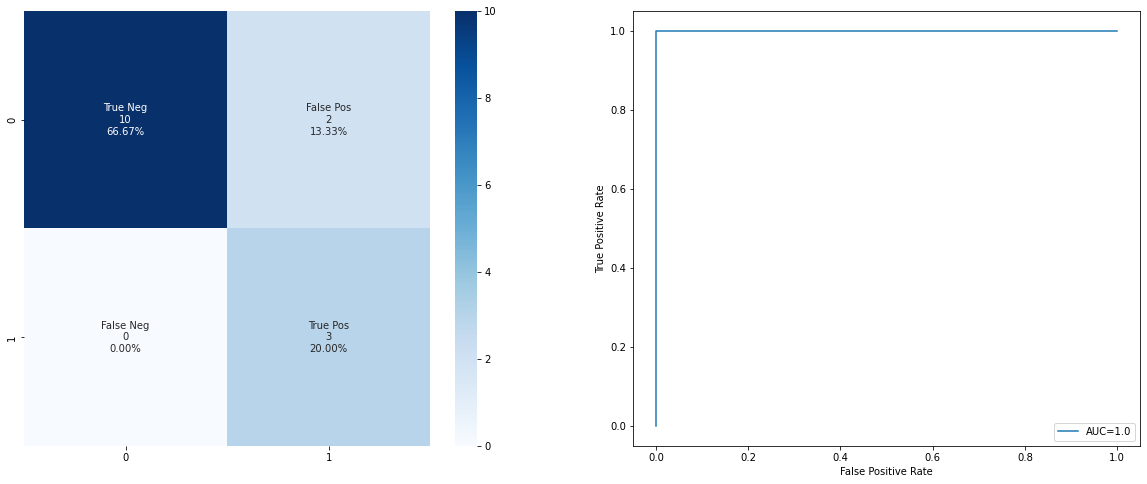

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.60      1.00      0.75         3

    accuracy                           0.87        15
   macro avg       0.80      0.92      0.83        15
weighted avg       0.92      0.87      0.88        15



In [111]:
features = ['smile_score_max', 'smile_score_mean',
       'HLCS_max', 'HLCS_mean', 'NLCS_max', 'NLCS_mean', 'TFIDF_simmat_max',
       'TFIDF_simmat_mean', 'TF_simmat_max', 'TF_simmat_mean', 'complingo_max',
       'complingo_mean', 'comptfidf_max', 'comptfidf_mean', 'edit_max',
       'edit_mean', 'lingo3_max', 'lingo3_mean', 'lingo4_max', 'lingo4_mean',
       'lingo5_max', 'lingo5_mean', 'smifp34Man_max', 'smifp34Man_mean',
       'smifp34Tan_max', 'smifp34Tan_mean', 'smifp38Man_max',
       'smifp38Man_mean', 'smifp38Tan_max', 'smifp38Tan_mean', 'substring_max',
       'substring_mean', 'target_align_score_max', 'target_align_score_mean',
       'kmer4_max', 'kmer4_mean', 'kmer3_max', 'kmer3_mean', 'kmer2_max',
       'kmer2_mean', 'kmer1_max', 'kmer1_mean', 'default_protein_max',
       'default_protein_mean', 'default_compound_max', 'default_compound_mean',
       'count_drug', 'count_target', 'adj_smile_max',
       'adj_sequence_max', 'adj_kmer1_max', 'adj_kmer2_max', 'adj_kmer3_max',
       'adj_kmer4_max', 'adj_default_protein_max', 'adj_default_compound_max',
       'adj_HLCS_max', 'adj_NLCS_max', 'adj_TFIDF_simmat_max',
       'adj_TF_simmat_max', 'adj_complingo_max', 'adj_edit_max',
       'adj_lingo3_max', 'adj_lingo4_max', 'adj_lingo5_max',
       'adj_smifp34Man_max', 'adj_smifp34Tan_max', 'adj_comptfidf_max',
       'adj_comptfidf_mean', 'adj_smile_mean', 'adj_sequence_mean',
       'adj_kmer1_mean', 'adj_kmer2_mean', 'adj_kmer3_mean', 'adj_kmer4_mean',
       'adj_default_protein_mean', 'adj_default_compound_mean',
       'adj_HLCS_mean', 'adj_NLCS_mean', 'adj_TFIDF_simmat_mean',
       'adj_TF_simmat_mean', 'adj_complingo_mean', 'adj_edit_mean',
       'adj_lingo3_mean', 'adj_lingo4_mean', 'adj_lingo5_mean',
       'adj_smifp34Man_mean', 'adj_smifp34Tan_mean']

# Split into X_train, y_train, X_test, y_test
X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

y_train = train['target'].astype(int)

y_test = test['target'].astype(int)


    
data_name = 'NuclearReceptor 1:5'
print("Results of " , data_name)

# Train and test the model
model_name = 'RandomForest'
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1, TP = confusionMat_v2(y_test, y_pred, y_prob, model_name)
#Save 
df_list = [data_name, auprc, auc, precision_class0, recall_class0, precision_class1, recall_class1, accuracy, f1]
metricTable.loc[len(metricTable)] = df_list

In [112]:
unknown_df =  df_scores[df_scores['index'].isin(unknown['index'].tolist())]
unknown_df

,index,drugID,targetID,smile_score_max,smile_score_mean,HLCS_max,HLCS_mean,NLCS_max,NLCS_mean,TFIDF_simmat_max,...,adj_NLCS_mean,adj_TFIDF_simmat_mean,adj_TF_simmat_mean,adj_complingo_mean,adj_edit_mean,adj_lingo3_mean,adj_lingo4_mean,adj_lingo5_mean,adj_smifp34Man_mean,adj_smifp34Tan_mean
1,1,D00002,hsa107,0.483871,0.437935,0.15508,0.13910,0.39847,0.360495,0.46062,...,0.72099,0.80459,1.2024,0.697825,0.760683,0.561813,0.50676,0.502185,0.04422,1.06594
2,2,D00002,hsa108,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,D00002,hsa109,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,D00002,hsa111,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,D00002,hsa112,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,5847,D03720,hsa64902,0.015748,0.015748,0.02985,0.02985,0.08224,0.082240,0.00000,...,0.08224,0.0,0.0,0.011111,0.140625,0.018182,0.0,0.0,0.02174,0.34259
5848,5848,D00667,hsa79799,0.169643,0.169643,0.06775,0.06775,0.19512,0.195120,0.16687,...,0.19512,0.16687,0.33083,0.218914,0.330579,0.196322,0.13116,0.077778,0.02564,0.41964
5849,5849,D00401,hsa8192,0.022222,0.022222,0.00762,0.00762,0.01538,0.015380,0.00000,...,0.01538,0.0,0.0,0.029412,0.1,0.0,0.0,0.0,0.04167,0.10714
5850,5850,D00593,hsa635,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
# Make predictions
y_prob_unknown = rf.predict_proba(unknown_df[features])[:, 1]
# Create DataFrame with training data and predictions
train_with_predictions = unknown_df.copy()
train_with_predictions['prediction'] = y_prob_unknown

In [114]:
train_with_predictions.sort_values("prediction",ascending=False).head(20)[["drugID" , "targetID","prediction"]]

,drugID,targetID,prediction
803,D00410,hsa1571,1.0
1912,D01712,hsa5144,1.0
853,D00417,hsa5141,1.0
850,D00417,hsa5137,1.0
849,D00417,hsa5136,1.0
846,D00417,hsa50940,1.0
837,D00417,hsa10846,1.0
830,D00410,hsa64816,1.0
820,D00410,hsa260293,1.0
2168,D02451,hsa1548,1.0
